# Import Library & Preprocess Data 

In [51]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### Set Seed 

In [52]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

#### Config 

In [53]:
IMAGE_PATH = f'./datasets/golfdb_mod/'

batch_size = 128
size = 256

classes = 3

learning_rate = 1e-2
wd = 0.0005
max_lr = 1e-2
min_lr = 5e-5
cycle_len = 20

EPOCHS = 15000

#### Load Data

In [80]:
df_0 = pd.read_csv(f'./target_0.csv', header=None)
df_0 = df_0.dropna()
df_1 = pd.read_csv(f'./target_1.csv', header=None)
df_1 = df_1.dropna()
df_2 = pd.read_csv(f'./target_2.csv', header=None)
df_2 = df_2.dropna()

In [55]:
df = pd.concat([df_0, df_1, df_2], axis=0, ignore_index=True)
# df = pd.concat([df_0, df_1], axis=0, ignore_index=True)

In [56]:
len(df[df[34]==0]), len(df[df[34]==1]), len(df[df[34]==2]) 

(700, 701, 500)

In [57]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.031738,0.479105,0.005573,0.596298,0.0,0.430337,0.024846,0.638349,0.017402,0.299632,...,0.379505,0.795137,0.733983,0.773684,0.564830,0.965573,0.554677,1.000000,0.339502,0
1,0.028432,0.367674,0.000161,0.478395,0.0,0.320556,0.017301,0.701826,0.023375,0.245548,...,0.274433,0.758311,0.561541,0.763065,0.403513,1.000000,0.708335,0.997456,0.556775,0
2,0.027062,0.454876,0.001957,0.536082,0.0,0.368329,0.032237,0.608868,0.024970,0.292349,...,0.288567,0.813054,0.817295,0.782078,0.302132,0.993143,0.732183,1.000000,0.353248,0
3,0.033873,0.473104,0.004323,0.544605,0.0,0.406965,0.031307,0.629818,0.022855,0.286762,...,0.226300,0.757614,0.549769,0.740944,0.259274,1.000000,0.440894,0.987412,0.197907,0
4,0.031973,0.525920,0.011531,0.625662,0.0,0.480184,0.042187,0.726601,0.028264,0.375862,...,0.271959,0.844635,0.631846,0.837735,0.254223,0.995301,0.791610,1.000000,0.333158,0


In [58]:
y = df.pop(34)

total_dataset = tf.data.Dataset.from_tensor_slices((df.values, y.values))
total_dataset = total_dataset.shuffle(len(df)).batch(batch_size)

In [59]:
f,v = next(iter(total_dataset))
f.shape, v.shape

(TensorShape([128, 34]), TensorShape([128]))

In [73]:
df.isnull().sum().sum()

0

In [81]:
total_tsne_0 = TSNE(learning_rate=300).fit_transform(df_0.values)
total_tsne_1 = TSNE(learning_rate=300).fit_transform(df_1.values)
total_tsne_2 = TSNE(learning_rate=300).fit_transform(df_2.values)

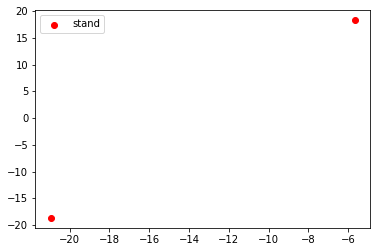

In [85]:
plt.scatter(total_tsne_0[0], total_tsne_0[1], color='red', label='stand')
plt.scatter(total_tsne_0[0], total_tsne_0[1], color='blue', label='squat')
plt.scatter(total_tsne_0[0], total_tsne_0[1], color='green', label='bent')
plt.legend()
plt.show()

# Load Model

In [10]:
def MetricLearning():
    pose = inputs = Input([34])
    x = Dense(128, activation='relu')(pose)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(128, activation=None)(x)
    return Model(inputs=inputs, outputs=output)

In [11]:
model = MetricLearning()

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4480      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
Total params: 37,504
Trainable params: 37,504
Non-trainable params: 0
__________________________________________________

# Compile

In [13]:
# optimizer = tfa.optimizers.AdamW(learning_rate, wd)
# optimizer = tf.keras.optimizers.Adam(learning_rate)
optimizer = tf.keras.optimizers.SGD(learning_rate)

model.compile(
    optimizer = optimizer,
    loss = tfa.losses.TripletSemiHardLoss(),
)

In [14]:
checkpoint_filepath = './checkpoints/triplet_model.h5'
# checkpoint_filepath = './checkpoints/best_model/'
mon = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False,
                                                monitor='loss', mode='min', save_best_only=True, verbose=1)

def trianfle_fn(x):
    return 1. / (2.**(x - 1))
clr_f = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = max_lr,
    maximal_learning_rate = min_lr,
    step_size = cycle_len,
    scale_fn = trianfle_fn
)

clr = tf.keras.callbacks.LearningRateScheduler(clr_f)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1000, 
                                          verbose=2, mode='auto', baseline=None, 
                                          restore_best_weights=True)

# callbacks = [mon, clr, es]
callbacks = [mon, clr]
# callbacks = [clr, es]
# callbacks = [clr]
# callbacks = []

# Training Metric

In [15]:
history = model.fit(
    total_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9882
Epoch 00001: loss improved from inf to 0.99491, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9949
Epoch 2/15000
 1/15 [=>............................] - ETA: 0s - loss: 1.0000
Epoch 00002: loss did not improve from 0.99491
15/15 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 3/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9999
Epoch 00003: loss did not improve from 0.99491
15/15 [==============================] - 0s 3ms/step - loss: 0.9999
Epoch 4/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9999
Epoch 00004: loss did not improve from 0.99491
15/15 [==============================] - 0s 3ms/step - loss: 0.9999
Epoch 5/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9998
Epoch 00005: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - 

 1/15 [=>............................] - ETA: 0s - loss: 0.9994
Epoch 00043: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9989
Epoch 44/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9987
Epoch 00044: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9989
Epoch 45/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9988
Epoch 00045: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9988
Epoch 46/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9985
Epoch 00046: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9988
Epoch 47/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9991
Epoch 00047: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9987
Epoch 48/15000
 1/15 [=>.....................

 1/15 [=>............................] - ETA: 0s - loss: 0.9972
Epoch 00085: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9975
Epoch 86/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9972
Epoch 00086: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9974
Epoch 87/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9974
Epoch 00087: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9973
Epoch 88/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9974
Epoch 00088: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9972
Epoch 89/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9977
Epoch 00089: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9973
Epoch 90/15000
 1/15 [=>.....................

 1/15 [=>............................] - ETA: 0s - loss: 0.9952
Epoch 00127: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9957
Epoch 128/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9963
Epoch 00128: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9954
Epoch 129/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9945
Epoch 00129: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9955
Epoch 130/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9952
Epoch 00130: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9958
Epoch 131/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9972
Epoch 00131: loss did not improve from 0.99491
15/15 [==============================] - 0s 2ms/step - loss: 0.9959
Epoch 132/15000
 1/15 [=>................

 1/15 [=>............................] - ETA: 0s - loss: 0.9961
Epoch 00167: loss did not improve from 0.99366
15/15 [==============================] - 0s 2ms/step - loss: 0.9949
Epoch 168/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9937
Epoch 00168: loss did not improve from 0.99366
15/15 [==============================] - 0s 2ms/step - loss: 0.9940
Epoch 169/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9947
Epoch 00169: loss did not improve from 0.99366
15/15 [==============================] - 0s 2ms/step - loss: 0.9940
Epoch 170/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9934
Epoch 00170: loss improved from 0.99366 to 0.99330, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9933
Epoch 171/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9938
Epoch 00171: loss did not improve from 0.99330
15/15 [==============================] - 0s 2ms/step - lo

Epoch 208/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9943
Epoch 00208: loss did not improve from 0.99201
15/15 [==============================] - 0s 2ms/step - loss: 0.9930
Epoch 209/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9934
Epoch 00209: loss improved from 0.99201 to 0.99194, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9919
Epoch 210/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9941
Epoch 00210: loss did not improve from 0.99194
15/15 [==============================] - 0s 2ms/step - loss: 0.9926
Epoch 211/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9925
Epoch 00211: loss improved from 0.99194 to 0.99137, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9914
Epoch 212/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9882
Epoch 00212: loss did not improve fr

Epoch 249/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9905
Epoch 00249: loss improved from 0.98999 to 0.98916, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9892
Epoch 250/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9904
Epoch 00250: loss did not improve from 0.98916
15/15 [==============================] - 0s 2ms/step - loss: 0.9901
Epoch 251/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9917
Epoch 00251: loss did not improve from 0.98916
15/15 [==============================] - 0s 2ms/step - loss: 0.9907
Epoch 252/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9847
Epoch 00252: loss did not improve from 0.98916
15/15 [==============================] - 0s 2ms/step - loss: 0.9896
Epoch 253/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9882
Epoch 00253: loss did not improve from 0.98916
15/15 [==============================] - 

Epoch 290/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9890
Epoch 00290: loss did not improve from 0.98747
15/15 [==============================] - 0s 2ms/step - loss: 0.9886
Epoch 291/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9894
Epoch 00291: loss did not improve from 0.98747
15/15 [==============================] - 0s 2ms/step - loss: 0.9884
Epoch 292/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9880
Epoch 00292: loss did not improve from 0.98747
15/15 [==============================] - 0s 2ms/step - loss: 0.9884
Epoch 293/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9873
Epoch 00293: loss did not improve from 0.98747
15/15 [==============================] - 0s 2ms/step - loss: 0.9881
Epoch 294/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9864
Epoch 00294: loss did not improve from 0.98747
15/15 [==============================] - 0s 2ms/step - loss: 0.9884
Epoch 295/15000
 1/15 [=>

Epoch 331/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9862
Epoch 00331: loss did not improve from 0.98612
15/15 [==============================] - 0s 2ms/step - loss: 0.9870
Epoch 332/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9869
Epoch 00332: loss did not improve from 0.98612
15/15 [==============================] - 0s 2ms/step - loss: 0.9878
Epoch 333/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9866
Epoch 00333: loss improved from 0.98612 to 0.98590, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9859
Epoch 334/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9882
Epoch 00334: loss did not improve from 0.98590
15/15 [==============================] - 0s 2ms/step - loss: 0.9870
Epoch 335/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9826
Epoch 00335: loss did not improve from 0.98590
15/15 [==============================] - 

 1/15 [=>............................] - ETA: 0s - loss: 0.9862
Epoch 00371: loss did not improve from 0.98382
15/15 [==============================] - 0s 2ms/step - loss: 0.9845
Epoch 372/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9880
Epoch 00372: loss did not improve from 0.98382
15/15 [==============================] - 0s 2ms/step - loss: 0.9857
Epoch 373/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9851
Epoch 00373: loss improved from 0.98382 to 0.98294, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9829
Epoch 374/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9869
Epoch 00374: loss did not improve from 0.98294
15/15 [==============================] - 0s 2ms/step - loss: 0.9831
Epoch 375/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9797
Epoch 00375: loss did not improve from 0.98294
15/15 [==============================] - 0s 2ms/step - lo

Epoch 412/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9821
Epoch 00412: loss did not improve from 0.98155
15/15 [==============================] - 0s 3ms/step - loss: 0.9826
Epoch 413/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9870
Epoch 00413: loss did not improve from 0.98155
15/15 [==============================] - 0s 2ms/step - loss: 0.9820
Epoch 414/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9701
Epoch 00414: loss did not improve from 0.98155
15/15 [==============================] - 0s 2ms/step - loss: 0.9824
Epoch 415/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9839
Epoch 00415: loss did not improve from 0.98155
15/15 [==============================] - 0s 2ms/step - loss: 0.9824
Epoch 416/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9821
Epoch 00416: loss did not improve from 0.98155
15/15 [==============================] - 0s 2ms/step - loss: 0.9824
Epoch 417/15000
 1/15 [=>

 1/15 [=>............................] - ETA: 0s - loss: 0.9829
Epoch 00453: loss did not improve from 0.97908
15/15 [==============================] - 0s 2ms/step - loss: 0.9818
Epoch 454/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9837
Epoch 00454: loss did not improve from 0.97908
15/15 [==============================] - 0s 2ms/step - loss: 0.9801
Epoch 455/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9826
Epoch 00455: loss did not improve from 0.97908
15/15 [==============================] - 0s 2ms/step - loss: 0.9816
Epoch 456/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9839
Epoch 00456: loss did not improve from 0.97908
15/15 [==============================] - 0s 2ms/step - loss: 0.9820
Epoch 457/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9807
Epoch 00457: loss did not improve from 0.97908
15/15 [==============================] - 0s 2ms/step - loss: 0.9791
Epoch 458/15000
 1/15 [=>................

Epoch 495/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9811
Epoch 00495: loss did not improve from 0.97750
15/15 [==============================] - 0s 2ms/step - loss: 0.9788
Epoch 496/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9824
Epoch 00496: loss did not improve from 0.97750
15/15 [==============================] - 0s 2ms/step - loss: 0.9790
Epoch 497/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9793
Epoch 00497: loss did not improve from 0.97750
15/15 [==============================] - 0s 2ms/step - loss: 0.9797
Epoch 498/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9798
Epoch 00498: loss did not improve from 0.97750
15/15 [==============================] - 0s 2ms/step - loss: 0.9787
Epoch 499/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9852
Epoch 00499: loss did not improve from 0.97750
15/15 [==============================] - 0s 2ms/step - loss: 0.9799
Epoch 500/15000
 1/15 [=>

Epoch 536/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9726
Epoch 00536: loss did not improve from 0.97338
15/15 [==============================] - 0s 2ms/step - loss: 0.9758
Epoch 537/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9760
Epoch 00537: loss did not improve from 0.97338
15/15 [==============================] - 0s 2ms/step - loss: 0.9759
Epoch 538/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9745
Epoch 00538: loss did not improve from 0.97338
15/15 [==============================] - 0s 2ms/step - loss: 0.9756
Epoch 539/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9810
Epoch 00539: loss did not improve from 0.97338
15/15 [==============================] - 0s 2ms/step - loss: 0.9757
Epoch 540/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9775
Epoch 00540: loss did not improve from 0.97338
15/15 [==============================] - 0s 2ms/step - loss: 0.9778
Epoch 541/15000
 1/15 [=>

 1/15 [=>............................] - ETA: 0s - loss: 0.9651
Epoch 00577: loss did not improve from 0.97219
15/15 [==============================] - 0s 2ms/step - loss: 0.9728
Epoch 578/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9738
Epoch 00578: loss did not improve from 0.97219
15/15 [==============================] - 0s 2ms/step - loss: 0.9770
Epoch 579/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9827
Epoch 00579: loss did not improve from 0.97219
15/15 [==============================] - 0s 2ms/step - loss: 0.9733
Epoch 580/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9817
Epoch 00580: loss did not improve from 0.97219
15/15 [==============================] - 0s 2ms/step - loss: 0.9735
Epoch 581/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9769
Epoch 00581: loss did not improve from 0.97219
15/15 [==============================] - 0s 2ms/step - loss: 0.9735
Epoch 582/15000
 1/15 [=>................

 1/15 [=>............................] - ETA: 0s - loss: 0.9751
Epoch 00618: loss did not improve from 0.96922
15/15 [==============================] - 0s 2ms/step - loss: 0.9696
Epoch 619/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9625
Epoch 00619: loss did not improve from 0.96922
15/15 [==============================] - 0s 2ms/step - loss: 0.9710
Epoch 620/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9746
Epoch 00620: loss did not improve from 0.96922
15/15 [==============================] - 0s 2ms/step - loss: 0.9711
Epoch 621/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9730
Epoch 00621: loss did not improve from 0.96922
15/15 [==============================] - 0s 2ms/step - loss: 0.9713
Epoch 622/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9812
Epoch 00622: loss did not improve from 0.96922
15/15 [==============================] - 0s 2ms/step - loss: 0.9719
Epoch 623/15000
 1/15 [=>................

Epoch 659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9727
Epoch 00659: loss did not improve from 0.96721
15/15 [==============================] - 0s 2ms/step - loss: 0.9684
Epoch 660/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9665
Epoch 00660: loss improved from 0.96721 to 0.96561, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9656
Epoch 661/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9699
Epoch 00661: loss did not improve from 0.96561
15/15 [==============================] - 0s 2ms/step - loss: 0.9699
Epoch 662/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9621
Epoch 00662: loss did not improve from 0.96561
15/15 [==============================] - 0s 2ms/step - loss: 0.9699
Epoch 663/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9735
Epoch 00663: loss did not improve from 0.96561
15/15 [==============================] - 

 1/15 [=>............................] - ETA: 0s - loss: 0.9724
Epoch 00700: loss did not improve from 0.96546
15/15 [==============================] - 0s 2ms/step - loss: 0.9681
Epoch 701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9624
Epoch 00701: loss improved from 0.96546 to 0.96392, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9639
Epoch 702/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9751
Epoch 00702: loss did not improve from 0.96392
15/15 [==============================] - 0s 2ms/step - loss: 0.9665
Epoch 703/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9633
Epoch 00703: loss did not improve from 0.96392
15/15 [==============================] - 0s 2ms/step - loss: 0.9647
Epoch 704/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9607
Epoch 00704: loss did not improve from 0.96392
15/15 [==============================] - 0s 2ms/step - lo

Epoch 741/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9640
Epoch 00741: loss did not improve from 0.96109
15/15 [==============================] - 0s 2ms/step - loss: 0.9656
Epoch 742/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9715
Epoch 00742: loss did not improve from 0.96109
15/15 [==============================] - 0s 2ms/step - loss: 0.9632
Epoch 743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9544
Epoch 00743: loss did not improve from 0.96109
15/15 [==============================] - 0s 2ms/step - loss: 0.9631
Epoch 744/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9550
Epoch 00744: loss improved from 0.96109 to 0.95958, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9596
Epoch 745/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9674
Epoch 00745: loss did not improve from 0.95958
15/15 [==============================] - 

Epoch 782/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9687
Epoch 00782: loss did not improve from 0.95570
15/15 [==============================] - 0s 2ms/step - loss: 0.9617
Epoch 783/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9659
Epoch 00783: loss did not improve from 0.95570
15/15 [==============================] - 0s 2ms/step - loss: 0.9621
Epoch 784/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9633
Epoch 00784: loss did not improve from 0.95570
15/15 [==============================] - 0s 2ms/step - loss: 0.9624
Epoch 785/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9719
Epoch 00785: loss did not improve from 0.95570
15/15 [==============================] - 0s 2ms/step - loss: 0.9620
Epoch 786/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9455
Epoch 00786: loss did not improve from 0.95570
15/15 [==============================] - 0s 2ms/step - loss: 0.9587
Epoch 787/15000
 1/15 [=>

Epoch 824/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9618
Epoch 00824: loss did not improve from 0.95460
15/15 [==============================] - 0s 2ms/step - loss: 0.9580
Epoch 825/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9763
Epoch 00825: loss did not improve from 0.95460
15/15 [==============================] - 0s 2ms/step - loss: 0.9581
Epoch 826/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9562
Epoch 00826: loss did not improve from 0.95460
15/15 [==============================] - 0s 2ms/step - loss: 0.9556
Epoch 827/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9484
Epoch 00827: loss did not improve from 0.95460
15/15 [==============================] - 0s 2ms/step - loss: 0.9569
Epoch 828/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9595
Epoch 00828: loss did not improve from 0.95460
15/15 [==============================] - 0s 2ms/step - loss: 0.9579
Epoch 829/15000
 1/15 [=>

 1/15 [=>............................] - ETA: 0s - loss: 0.9559
Epoch 00865: loss did not improve from 0.95045
15/15 [==============================] - 0s 2ms/step - loss: 0.9574
Epoch 866/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9405
Epoch 00866: loss did not improve from 0.95045
15/15 [==============================] - 0s 2ms/step - loss: 0.9530
Epoch 867/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9390
Epoch 00867: loss did not improve from 0.95045
15/15 [==============================] - 0s 2ms/step - loss: 0.9555
Epoch 868/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9687
Epoch 00868: loss did not improve from 0.95045
15/15 [==============================] - 0s 2ms/step - loss: 0.9576
Epoch 869/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9595
Epoch 00869: loss did not improve from 0.95045
15/15 [==============================] - 0s 2ms/step - loss: 0.9550
Epoch 870/15000
 1/15 [=>................

Epoch 907/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9439
Epoch 00907: loss did not improve from 0.94611
15/15 [==============================] - 0s 2ms/step - loss: 0.9491
Epoch 908/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9431
Epoch 00908: loss did not improve from 0.94611
15/15 [==============================] - 0s 2ms/step - loss: 0.9516
Epoch 909/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9386
Epoch 00909: loss did not improve from 0.94611
15/15 [==============================] - 0s 2ms/step - loss: 0.9502
Epoch 910/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9564
Epoch 00910: loss did not improve from 0.94611
15/15 [==============================] - 0s 2ms/step - loss: 0.9506
Epoch 911/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9524
Epoch 00911: loss did not improve from 0.94611
15/15 [==============================] - 0s 2ms/step - loss: 0.9511
Epoch 912/15000
 1/15 [=>

Epoch 949/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9480
Epoch 00949: loss did not improve from 0.94309
15/15 [==============================] - 0s 2ms/step - loss: 0.9493
Epoch 950/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9508
Epoch 00950: loss did not improve from 0.94309
15/15 [==============================] - 0s 2ms/step - loss: 0.9503
Epoch 951/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9340
Epoch 00951: loss did not improve from 0.94309
15/15 [==============================] - 0s 2ms/step - loss: 0.9435
Epoch 952/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9597
Epoch 00952: loss did not improve from 0.94309
15/15 [==============================] - 0s 2ms/step - loss: 0.9487
Epoch 953/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9343
Epoch 00953: loss did not improve from 0.94309
15/15 [==============================] - 0s 2ms/step - loss: 0.9474
Epoch 954/15000
 1/15 [=>

Epoch 991/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9373
Epoch 00991: loss did not improve from 0.93934
15/15 [==============================] - 0s 2ms/step - loss: 0.9439
Epoch 992/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9410
Epoch 00992: loss improved from 0.93934 to 0.93916, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9392
Epoch 993/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9436
Epoch 00993: loss did not improve from 0.93916
15/15 [==============================] - 0s 2ms/step - loss: 0.9410
Epoch 994/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9259
Epoch 00994: loss did not improve from 0.93916
15/15 [==============================] - 0s 2ms/step - loss: 0.9398
Epoch 995/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9462
Epoch 00995: loss did not improve from 0.93916
15/15 [==============================] - 

Epoch 1032/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9254
Epoch 01032: loss improved from 0.93658 to 0.93393, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9339
Epoch 1033/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9328
Epoch 01033: loss did not improve from 0.93393
15/15 [==============================] - 0s 2ms/step - loss: 0.9392
Epoch 1034/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9312
Epoch 01034: loss did not improve from 0.93393
15/15 [==============================] - 0s 2ms/step - loss: 0.9395
Epoch 1035/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9444
Epoch 01035: loss did not improve from 0.93393
15/15 [==============================] - 0s 2ms/step - loss: 0.9445
Epoch 1036/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9350
Epoch 01036: loss did not improve from 0.93393
15/15 [=============================

Epoch 1073/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9422
Epoch 01073: loss did not improve from 0.93128
15/15 [==============================] - 0s 2ms/step - loss: 0.9341
Epoch 1074/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9449
Epoch 01074: loss did not improve from 0.93128
15/15 [==============================] - 0s 2ms/step - loss: 0.9426
Epoch 1075/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9361
Epoch 01075: loss did not improve from 0.93128
15/15 [==============================] - 0s 2ms/step - loss: 0.9359
Epoch 1076/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9584
Epoch 01076: loss did not improve from 0.93128
15/15 [==============================] - 0s 2ms/step - loss: 0.9383
Epoch 1077/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9500
Epoch 01077: loss did not improve from 0.93128
15/15 [==============================] - 0s 2ms/step - loss: 0.9342
Epoch 1078/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.9464
Epoch 01114: loss did not improve from 0.92570
15/15 [==============================] - 0s 2ms/step - loss: 0.9317
Epoch 1115/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9339
Epoch 01115: loss did not improve from 0.92570
15/15 [==============================] - 0s 2ms/step - loss: 0.9340
Epoch 1116/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9529
Epoch 01116: loss did not improve from 0.92570
15/15 [==============================] - 0s 2ms/step - loss: 0.9323
Epoch 1117/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9206
Epoch 01117: loss improved from 0.92570 to 0.92508, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9251
Epoch 1118/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9393
Epoch 01118: loss did not improve from 0.92508
15/15 [==============================] - 0s 2ms/step 

Epoch 1156/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9194
Epoch 01156: loss did not improve from 0.92508
15/15 [==============================] - 0s 2ms/step - loss: 0.9285
Epoch 1157/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9373
Epoch 01157: loss did not improve from 0.92508
15/15 [==============================] - 0s 2ms/step - loss: 0.9329
Epoch 1158/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9453
Epoch 01158: loss did not improve from 0.92508
15/15 [==============================] - 0s 2ms/step - loss: 0.9315
Epoch 1159/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8986
Epoch 01159: loss improved from 0.92508 to 0.92367, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9237
Epoch 1160/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9132
Epoch 01160: loss did not improve from 0.92367
15/15 [=============================

 1/15 [=>............................] - ETA: 0s - loss: 0.9199
Epoch 01197: loss improved from 0.92359 to 0.92247, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.9225
Epoch 1198/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9408
Epoch 01198: loss did not improve from 0.92247
15/15 [==============================] - 0s 2ms/step - loss: 0.9289
Epoch 1199/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9215
Epoch 01199: loss did not improve from 0.92247
15/15 [==============================] - 0s 2ms/step - loss: 0.9330
Epoch 1200/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9291
Epoch 01200: loss did not improve from 0.92247
15/15 [==============================] - 0s 2ms/step - loss: 0.9353
Epoch 1201/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9284
Epoch 01201: loss did not improve from 0.92247
15/15 [==============================] - 0s 2ms/step 

Epoch 1238/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9427
Epoch 01238: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9265
Epoch 1239/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9343
Epoch 01239: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9279
Epoch 1240/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9298
Epoch 01240: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9299
Epoch 1241/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9345
Epoch 01241: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9347
Epoch 1242/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9363
Epoch 01242: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9319
Epoch 1243/15000
 1/

Epoch 1280/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9238
Epoch 01280: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9299
Epoch 1281/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9261
Epoch 01281: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9275
Epoch 1282/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9298
Epoch 01282: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9333
Epoch 1283/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9125
Epoch 01283: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9211
Epoch 1284/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9152
Epoch 01284: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9251
Epoch 1285/15000
 1/

Epoch 1322/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9337
Epoch 01322: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9270
Epoch 1323/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9107
Epoch 01323: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9276
Epoch 1324/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9302
Epoch 01324: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9263
Epoch 1325/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9347
Epoch 01325: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9240
Epoch 1326/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9302
Epoch 01326: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9256
Epoch 1327/15000
 1/

Epoch 1364/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9340
Epoch 01364: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9254
Epoch 1365/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9261
Epoch 01365: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9293
Epoch 1366/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9317
Epoch 01366: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9207
Epoch 1367/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9087
Epoch 01367: loss did not improve from 0.91927
15/15 [==============================] - 0s 2ms/step - loss: 0.9212
Epoch 1368/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9025
Epoch 01368: loss improved from 0.91927 to 0.91695, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

 1/15 [=>............................] - ETA: 0s - loss: 0.9207
Epoch 01405: loss did not improve from 0.91610
15/15 [==============================] - 0s 2ms/step - loss: 0.9185
Epoch 1406/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9351
Epoch 01406: loss did not improve from 0.91610
15/15 [==============================] - 0s 2ms/step - loss: 0.9233
Epoch 1407/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9209
Epoch 01407: loss did not improve from 0.91610
15/15 [==============================] - 0s 2ms/step - loss: 0.9250
Epoch 1408/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8904
Epoch 01408: loss did not improve from 0.91610
15/15 [==============================] - 0s 2ms/step - loss: 0.9238
Epoch 1409/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9381
Epoch 01409: loss did not improve from 0.91610
15/15 [==============================] - 0s 2ms/step - loss: 0.9275
Epoch 1410/15000
 1/15 [=>...........

Epoch 1447/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9432
Epoch 01447: loss did not improve from 0.91088
15/15 [==============================] - 0s 2ms/step - loss: 0.9244
Epoch 1448/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9135
Epoch 01448: loss did not improve from 0.91088
15/15 [==============================] - 0s 2ms/step - loss: 0.9182
Epoch 1449/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9130
Epoch 01449: loss did not improve from 0.91088
15/15 [==============================] - 0s 2ms/step - loss: 0.9172
Epoch 1450/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9369
Epoch 01450: loss did not improve from 0.91088
15/15 [==============================] - 0s 2ms/step - loss: 0.9225
Epoch 1451/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9359
Epoch 01451: loss did not improve from 0.91088
15/15 [==============================] - 0s 2ms/step - loss: 0.9249
Epoch 1452/15000
 1/

Epoch 1489/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9251
Epoch 01489: loss did not improve from 0.91064
15/15 [==============================] - 0s 2ms/step - loss: 0.9260
Epoch 1490/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9266
Epoch 01490: loss did not improve from 0.91064
15/15 [==============================] - 0s 2ms/step - loss: 0.9210
Epoch 1491/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9363
Epoch 01491: loss did not improve from 0.91064
15/15 [==============================] - 0s 2ms/step - loss: 0.9216
Epoch 1492/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9200
Epoch 01492: loss did not improve from 0.91064
15/15 [==============================] - 0s 2ms/step - loss: 0.9243
Epoch 1493/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9162
Epoch 01493: loss did not improve from 0.91064
15/15 [==============================] - 0s 2ms/step - loss: 0.9205
Epoch 1494/15000
 1/

Epoch 1530/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8950
Epoch 01530: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9160
Epoch 1531/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8882
Epoch 01531: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9138
Epoch 1532/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9180
Epoch 01532: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9161
Epoch 1533/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9444
Epoch 01533: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9219
Epoch 1534/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9312
Epoch 01534: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9179
Epoch 1535/15000
 1/

Epoch 1572/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9316
Epoch 01572: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9178
Epoch 1573/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9299
Epoch 01573: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9109
Epoch 1574/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8735
Epoch 01574: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9095
Epoch 1575/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9184
Epoch 01575: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9166
Epoch 1576/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9358
Epoch 01576: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9085
Epoch 1577/15000
 1/

Epoch 1614/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9271
Epoch 01614: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9161
Epoch 1615/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8625
Epoch 01615: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9093
Epoch 1616/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9240
Epoch 01616: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9121
Epoch 1617/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9293
Epoch 01617: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9112
Epoch 1618/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9362
Epoch 01618: loss did not improve from 0.90758
15/15 [==============================] - 0s 2ms/step - loss: 0.9105
Epoch 1619/15000
 1/

Epoch 1656/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9039
Epoch 01656: loss did not improve from 0.90659
15/15 [==============================] - 0s 2ms/step - loss: 0.9094
Epoch 1657/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9294
Epoch 01657: loss did not improve from 0.90659
15/15 [==============================] - 0s 2ms/step - loss: 0.9105
Epoch 1658/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8872
Epoch 01658: loss did not improve from 0.90659
15/15 [==============================] - 0s 2ms/step - loss: 0.9070
Epoch 1659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9274
Epoch 01659: loss did not improve from 0.90659
15/15 [==============================] - 0s 2ms/step - loss: 0.9163
Epoch 1660/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8931
Epoch 01660: loss did not improve from 0.90659
15/15 [==============================] - 0s 2ms/step - loss: 0.9115
Epoch 1661/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.9131
Epoch 01697: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9126
Epoch 1698/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8845
Epoch 01698: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9017
Epoch 1699/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9338
Epoch 01699: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9083
Epoch 1700/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9166
Epoch 01700: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9093
Epoch 1701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8965
Epoch 01701: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9004
Epoch 1702/15000
 1/15 [=>...........

Epoch 1739/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9031
Epoch 01739: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9044
Epoch 1740/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8870
Epoch 01740: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9092
Epoch 1741/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9075
Epoch 01741: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9143
Epoch 1742/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8875
Epoch 01742: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9162
Epoch 1743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8933
Epoch 01743: loss did not improve from 0.89868
15/15 [==============================] - 0s 2ms/step - loss: 0.9137
Epoch 1744/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.9212
Epoch 01780: loss did not improve from 0.89830
15/15 [==============================] - 0s 2ms/step - loss: 0.9054
Epoch 1781/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8773
Epoch 01781: loss did not improve from 0.89830
15/15 [==============================] - 0s 2ms/step - loss: 0.9038
Epoch 1782/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9062
Epoch 01782: loss did not improve from 0.89830
15/15 [==============================] - 0s 2ms/step - loss: 0.9136
Epoch 1783/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9238
Epoch 01783: loss did not improve from 0.89830
15/15 [==============================] - 0s 2ms/step - loss: 0.8994
Epoch 1784/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9263
Epoch 01784: loss did not improve from 0.89830
15/15 [==============================] - 0s 2ms/step - loss: 0.9015
Epoch 1785/15000
 1/15 [=>...........

 1/15 [=>............................] - ETA: 0s - loss: 0.9111
Epoch 01821: loss did not improve from 0.89766
15/15 [==============================] - 0s 2ms/step - loss: 0.9061
Epoch 1822/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8919
Epoch 01822: loss did not improve from 0.89766
15/15 [==============================] - 0s 2ms/step - loss: 0.9069
Epoch 1823/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8706
Epoch 01823: loss improved from 0.89766 to 0.89747, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.8975
Epoch 1824/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9125
Epoch 01824: loss did not improve from 0.89747
15/15 [==============================] - 0s 2ms/step - loss: 0.9076
Epoch 1825/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9062
Epoch 01825: loss did not improve from 0.89747
15/15 [==============================] - 0s 2ms/step 

 1/15 [=>............................] - ETA: 0s - loss: 0.9419
Epoch 01862: loss did not improve from 0.89539
15/15 [==============================] - 0s 2ms/step - loss: 0.9065
Epoch 1863/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9116
Epoch 01863: loss did not improve from 0.89539
15/15 [==============================] - 0s 2ms/step - loss: 0.9063
Epoch 1864/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9145
Epoch 01864: loss did not improve from 0.89539
15/15 [==============================] - 0s 2ms/step - loss: 0.9046
Epoch 1865/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9140
Epoch 01865: loss did not improve from 0.89539
15/15 [==============================] - 0s 2ms/step - loss: 0.9044
Epoch 1866/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9381
Epoch 01866: loss did not improve from 0.89539
15/15 [==============================] - 0s 2ms/step - loss: 0.9013
Epoch 1867/15000
 1/15 [=>...........

Epoch 1904/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8744
Epoch 01904: loss did not improve from 0.89265
15/15 [==============================] - 0s 2ms/step - loss: 0.8992
Epoch 1905/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9026
Epoch 01905: loss did not improve from 0.89265
15/15 [==============================] - 0s 2ms/step - loss: 0.8931
Epoch 1906/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9076
Epoch 01906: loss did not improve from 0.89265
15/15 [==============================] - 0s 2ms/step - loss: 0.9001
Epoch 1907/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9011
Epoch 01907: loss did not improve from 0.89265
15/15 [==============================] - 0s 2ms/step - loss: 0.9034
Epoch 1908/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8951
Epoch 01908: loss did not improve from 0.89265
15/15 [==============================] - 0s 2ms/step - loss: 0.8950
Epoch 1909/15000
 1/

Epoch 1946/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9005
Epoch 01946: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8967
Epoch 1947/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9031
Epoch 01947: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.9010
Epoch 1948/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8736
Epoch 01948: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8919
Epoch 1949/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8607
Epoch 01949: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8930
Epoch 1950/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9430
Epoch 01950: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8972
Epoch 1951/15000
 1/

Epoch 1988/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9105
Epoch 01988: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8962
Epoch 1989/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8568
Epoch 01989: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8932
Epoch 1990/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8951
Epoch 01990: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8972
Epoch 1991/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8506
Epoch 01991: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.9005
Epoch 1992/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9147
Epoch 01992: loss did not improve from 0.89020
15/15 [==============================] - 0s 2ms/step - loss: 0.8903
Epoch 1993/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8990
Epoch 02029: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.9006
Epoch 2030/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8966
Epoch 02030: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8868
Epoch 2031/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8654
Epoch 02031: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8907
Epoch 2032/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8832
Epoch 02032: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8992
Epoch 2033/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9107
Epoch 02033: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8995
Epoch 2034/15000
 1/15 [=>...........

Epoch 2071/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8798
Epoch 02071: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8942
Epoch 2072/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9108
Epoch 02072: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8892
Epoch 2073/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8963
Epoch 02073: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.9007
Epoch 2074/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8866
Epoch 02074: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8897
Epoch 2075/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8964
Epoch 02075: loss did not improve from 0.88538
15/15 [==============================] - 0s 2ms/step - loss: 0.8897
Epoch 2076/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.9143
Epoch 02112: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8998
Epoch 2113/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8578
Epoch 02113: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8920
Epoch 2114/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8900
Epoch 02114: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8918
Epoch 2115/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8924
Epoch 02115: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8945
Epoch 2116/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8978
Epoch 02116: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8981
Epoch 2117/15000
 1/15 [=>...........

Epoch 2154/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9069
Epoch 02154: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8846
Epoch 2155/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8821
Epoch 02155: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8877
Epoch 2156/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9003
Epoch 02156: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8930
Epoch 2157/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8979
Epoch 02157: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8893
Epoch 2158/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8869
Epoch 02158: loss did not improve from 0.87962
15/15 [==============================] - 0s 2ms/step - loss: 0.8854
Epoch 2159/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.9185
Epoch 02195: loss did not improve from 0.87517
15/15 [==============================] - 0s 2ms/step - loss: 0.8904
Epoch 2196/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9034
Epoch 02196: loss did not improve from 0.87517
15/15 [==============================] - 0s 2ms/step - loss: 0.8847
Epoch 2197/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8945
Epoch 02197: loss did not improve from 0.87517
15/15 [==============================] - 0s 2ms/step - loss: 0.8940
Epoch 2198/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8688
Epoch 02198: loss did not improve from 0.87517
15/15 [==============================] - 0s 2ms/step - loss: 0.8890
Epoch 2199/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8858
Epoch 02199: loss did not improve from 0.87517
15/15 [==============================] - 0s 2ms/step - loss: 0.8944
Epoch 2200/15000
 1/15 [=>...........

 1/15 [=>............................] - ETA: 0s - loss: 0.9067
Epoch 02236: loss did not improve from 0.87331
15/15 [==============================] - 0s 2ms/step - loss: 0.8872
Epoch 2237/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9036
Epoch 02237: loss did not improve from 0.87331
15/15 [==============================] - 0s 2ms/step - loss: 0.8883
Epoch 2238/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8819
Epoch 02238: loss did not improve from 0.87331
15/15 [==============================] - 0s 2ms/step - loss: 0.8810
Epoch 2239/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8589
Epoch 02239: loss did not improve from 0.87331
15/15 [==============================] - 0s 2ms/step - loss: 0.8869
Epoch 2240/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9103
Epoch 02240: loss did not improve from 0.87331
15/15 [==============================] - 0s 2ms/step - loss: 0.8809
Epoch 2241/15000
 1/15 [=>...........

Epoch 2278/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8723
Epoch 02278: loss did not improve from 0.87076
15/15 [==============================] - 0s 2ms/step - loss: 0.8805
Epoch 2279/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8995
Epoch 02279: loss did not improve from 0.87076
15/15 [==============================] - 0s 2ms/step - loss: 0.8864
Epoch 2280/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8818
Epoch 02280: loss did not improve from 0.87076
15/15 [==============================] - 0s 2ms/step - loss: 0.8844
Epoch 2281/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8913
Epoch 02281: loss did not improve from 0.87076
15/15 [==============================] - 0s 2ms/step - loss: 0.8826
Epoch 2282/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8816
Epoch 02282: loss did not improve from 0.87076
15/15 [==============================] - 0s 2ms/step - loss: 0.8768
Epoch 2283/15000
 1/

Epoch 2320/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8722
Epoch 02320: loss did not improve from 0.86913
15/15 [==============================] - 0s 2ms/step - loss: 0.8760
Epoch 2321/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8680
Epoch 02321: loss did not improve from 0.86913
15/15 [==============================] - 0s 2ms/step - loss: 0.8697
Epoch 2322/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8675
Epoch 02322: loss did not improve from 0.86913
15/15 [==============================] - 0s 2ms/step - loss: 0.8827
Epoch 2323/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8807
Epoch 02323: loss did not improve from 0.86913
15/15 [==============================] - 0s 2ms/step - loss: 0.8814
Epoch 2324/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8769
Epoch 02324: loss did not improve from 0.86913
15/15 [==============================] - 0s 2ms/step - loss: 0.8788
Epoch 2325/15000
 1/

Epoch 2362/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8837
Epoch 02362: loss did not improve from 0.86630
15/15 [==============================] - 0s 2ms/step - loss: 0.8831
Epoch 2363/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8902
Epoch 02363: loss did not improve from 0.86630
15/15 [==============================] - 0s 2ms/step - loss: 0.8839
Epoch 2364/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8624
Epoch 02364: loss did not improve from 0.86630
15/15 [==============================] - 0s 2ms/step - loss: 0.8739
Epoch 2365/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8928
Epoch 02365: loss did not improve from 0.86630
15/15 [==============================] - 0s 2ms/step - loss: 0.8778
Epoch 2366/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9035
Epoch 02366: loss did not improve from 0.86630
15/15 [==============================] - 0s 2ms/step - loss: 0.8797
Epoch 2367/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8619
Epoch 02403: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8784
Epoch 2404/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8893
Epoch 02404: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8673
Epoch 2405/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8487
Epoch 02405: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8723
Epoch 2406/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8400
Epoch 02406: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8668
Epoch 2407/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8636
Epoch 02407: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8744
Epoch 2408/15000
 1/15 [=>...........

Epoch 2445/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8901
Epoch 02445: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8661
Epoch 2446/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9007
Epoch 02446: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8747
Epoch 2447/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8395
Epoch 02447: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8695
Epoch 2448/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8807
Epoch 02448: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8796
Epoch 2449/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8416
Epoch 02449: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8781
Epoch 2450/15000
 1/

Epoch 2487/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8966
Epoch 02487: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8728
Epoch 2488/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8682
Epoch 02488: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8696
Epoch 2489/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8578
Epoch 02489: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8697
Epoch 2490/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8846
Epoch 02490: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8799
Epoch 2491/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8750
Epoch 02491: loss did not improve from 0.85684
15/15 [==============================] - 0s 2ms/step - loss: 0.8764
Epoch 2492/15000
 1/

Epoch 2529/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8863
Epoch 02529: loss did not improve from 0.85438
15/15 [==============================] - 0s 2ms/step - loss: 0.8744
Epoch 2530/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8501
Epoch 02530: loss did not improve from 0.85438
15/15 [==============================] - 0s 2ms/step - loss: 0.8620
Epoch 2531/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8683
Epoch 02531: loss did not improve from 0.85438
15/15 [==============================] - 0s 2ms/step - loss: 0.8553
Epoch 2532/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8288
Epoch 02532: loss did not improve from 0.85438
15/15 [==============================] - 0s 2ms/step - loss: 0.8610
Epoch 2533/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8738
Epoch 02533: loss did not improve from 0.85438
15/15 [==============================] - 0s 2ms/step - loss: 0.8681
Epoch 2534/15000
 1/

Epoch 2571/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8728
Epoch 02571: loss did not improve from 0.85412
15/15 [==============================] - 0s 2ms/step - loss: 0.8671
Epoch 2572/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8578
Epoch 02572: loss did not improve from 0.85412
15/15 [==============================] - 0s 2ms/step - loss: 0.8718
Epoch 2573/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8195
Epoch 02573: loss did not improve from 0.85412
15/15 [==============================] - 0s 2ms/step - loss: 0.8609
Epoch 2574/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8539
Epoch 02574: loss did not improve from 0.85412
15/15 [==============================] - 0s 2ms/step - loss: 0.8658
Epoch 2575/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8498
Epoch 02575: loss did not improve from 0.85412
15/15 [==============================] - 0s 2ms/step - loss: 0.8667
Epoch 2576/15000
 1/

Epoch 2613/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8558
Epoch 02613: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8677
Epoch 2614/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8977
Epoch 02614: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8624
Epoch 2615/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8696
Epoch 02615: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8591
Epoch 2616/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8717
Epoch 02616: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8748
Epoch 2617/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8663
Epoch 02617: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8607
Epoch 2618/15000
 1/

Epoch 2655/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8126
Epoch 02655: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8630
Epoch 2656/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8672
Epoch 02656: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8602
Epoch 2657/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8483
Epoch 02657: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8634
Epoch 2658/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8832
Epoch 02658: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8604
Epoch 2659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9040
Epoch 02659: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8658
Epoch 2660/15000
 1/

Epoch 2697/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8552
Epoch 02697: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8568
Epoch 2698/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8720
Epoch 02698: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8521
Epoch 2699/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8735
Epoch 02699: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8671
Epoch 2700/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8982
Epoch 02700: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8631
Epoch 2701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8445
Epoch 02701: loss did not improve from 0.85128
15/15 [==============================] - 0s 2ms/step - loss: 0.8606
Epoch 2702/15000
 1/

Epoch 2739/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8455
Epoch 02739: loss did not improve from 0.84892
15/15 [==============================] - 0s 2ms/step - loss: 0.8609
Epoch 2740/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8766
Epoch 02740: loss did not improve from 0.84892
15/15 [==============================] - 0s 2ms/step - loss: 0.8624
Epoch 2741/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8820
Epoch 02741: loss did not improve from 0.84892
15/15 [==============================] - 0s 2ms/step - loss: 0.8615
Epoch 2742/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8352
Epoch 02742: loss did not improve from 0.84892
15/15 [==============================] - 0s 2ms/step - loss: 0.8754
Epoch 2743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8967
Epoch 02743: loss did not improve from 0.84892
15/15 [==============================] - 0s 2ms/step - loss: 0.8525
Epoch 2744/15000
 1/

Epoch 2781/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8186
Epoch 02781: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8545
Epoch 2782/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8191
Epoch 02782: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8552
Epoch 2783/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8323
Epoch 02783: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8583
Epoch 2784/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8698
Epoch 02784: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8546
Epoch 2785/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8241
Epoch 02785: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8625
Epoch 2786/15000
 1/

Epoch 2823/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8606
Epoch 02823: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8577
Epoch 2824/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8489
Epoch 02824: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8633
Epoch 2825/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8848
Epoch 02825: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8599
Epoch 2826/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8460
Epoch 02826: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8641
Epoch 2827/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8316
Epoch 02827: loss did not improve from 0.84545
15/15 [==============================] - 0s 2ms/step - loss: 0.8635
Epoch 2828/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8559
Epoch 02864: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8613
Epoch 2865/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8639
Epoch 02865: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8614
Epoch 2866/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8372
Epoch 02866: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8556
Epoch 2867/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8661
Epoch 02867: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8548
Epoch 2868/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8602
Epoch 02868: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8585
Epoch 2869/15000
 1/15 [=>...........

Epoch 2906/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8701
Epoch 02906: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8532
Epoch 2907/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8943
Epoch 02907: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8545
Epoch 2908/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8744
Epoch 02908: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8540
Epoch 2909/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.9073
Epoch 02909: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8586
Epoch 2910/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8543
Epoch 02910: loss did not improve from 0.84072
15/15 [==============================] - 0s 2ms/step - loss: 0.8521
Epoch 2911/15000
 1/

Epoch 2948/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8658
Epoch 02948: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8565
Epoch 2949/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8222
Epoch 02949: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8503
Epoch 2950/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8800
Epoch 02950: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8586
Epoch 2951/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8577
Epoch 02951: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8519
Epoch 2952/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8372
Epoch 02952: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8478
Epoch 2953/15000
 1/

Epoch 2990/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8804
Epoch 02990: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8452
Epoch 2991/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8883
Epoch 02991: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8540
Epoch 2992/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8795
Epoch 02992: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8574
Epoch 2993/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8477
Epoch 02993: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8600
Epoch 2994/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8691
Epoch 02994: loss did not improve from 0.83962
15/15 [==============================] - 0s 2ms/step - loss: 0.8591
Epoch 2995/15000
 1/

Epoch 3032/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8804
Epoch 03032: loss did not improve from 0.83826
15/15 [==============================] - 0s 2ms/step - loss: 0.8456
Epoch 3033/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8308
Epoch 03033: loss did not improve from 0.83826
15/15 [==============================] - 0s 2ms/step - loss: 0.8482
Epoch 3034/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8701
Epoch 03034: loss did not improve from 0.83826
15/15 [==============================] - 0s 2ms/step - loss: 0.8525
Epoch 3035/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8673
Epoch 03035: loss did not improve from 0.83826
15/15 [==============================] - 0s 2ms/step - loss: 0.8554
Epoch 3036/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8635
Epoch 03036: loss did not improve from 0.83826
15/15 [==============================] - 0s 2ms/step - loss: 0.8582
Epoch 3037/15000
 1/

15/15 [==============================] - 0s 2ms/step - loss: 0.8439
Epoch 3074/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8451
Epoch 03074: loss did not improve from 0.83785
15/15 [==============================] - 0s 2ms/step - loss: 0.8512
Epoch 3075/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8153
Epoch 03075: loss did not improve from 0.83785
15/15 [==============================] - 0s 2ms/step - loss: 0.8464
Epoch 3076/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8225
Epoch 03076: loss did not improve from 0.83785
15/15 [==============================] - 0s 2ms/step - loss: 0.8500
Epoch 3077/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8595
Epoch 03077: loss did not improve from 0.83785
15/15 [==============================] - 0s 2ms/step - loss: 0.8507
Epoch 3078/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8666
Epoch 03078: loss did not improve from 0.83785
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.8569
Epoch 03115: loss did not improve from 0.83731
15/15 [==============================] - 0s 2ms/step - loss: 0.8539
Epoch 3116/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8597
Epoch 03116: loss did not improve from 0.83731
15/15 [==============================] - 0s 2ms/step - loss: 0.8487
Epoch 3117/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8504
Epoch 03117: loss did not improve from 0.83731
15/15 [==============================] - 0s 2ms/step - loss: 0.8375
Epoch 3118/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8391
Epoch 03118: loss did not improve from 0.83731
15/15 [==============================] - 0s 2ms/step - loss: 0.8485
Epoch 3119/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8569
Epoch 03119: loss did not improve from 0.83731
15/15 [==============================] - 0s 2ms/step - loss: 0.8465
Epoch 3120/15000
 1/15 [=>...........

Epoch 3157/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8513
Epoch 03157: loss did not improve from 0.83343
15/15 [==============================] - 0s 2ms/step - loss: 0.8409
Epoch 3158/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8530
Epoch 03158: loss did not improve from 0.83343
15/15 [==============================] - 0s 2ms/step - loss: 0.8558
Epoch 3159/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8461
Epoch 03159: loss did not improve from 0.83343
15/15 [==============================] - 0s 2ms/step - loss: 0.8460
Epoch 3160/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8508
Epoch 03160: loss did not improve from 0.83343
15/15 [==============================] - 0s 2ms/step - loss: 0.8455
Epoch 3161/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8459
Epoch 03161: loss did not improve from 0.83343
15/15 [==============================] - 0s 2ms/step - loss: 0.8533
Epoch 3162/15000
 1/

Epoch 03198: loss did not improve from 0.83232
15/15 [==============================] - 0s 2ms/step - loss: 0.8441
Epoch 3199/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8352
Epoch 03199: loss did not improve from 0.83232
15/15 [==============================] - 0s 2ms/step - loss: 0.8465
Epoch 3200/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8529
Epoch 03200: loss did not improve from 0.83232
15/15 [==============================] - 0s 2ms/step - loss: 0.8474
Epoch 3201/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8091
Epoch 03201: loss did not improve from 0.83232
15/15 [==============================] - 0s 2ms/step - loss: 0.8495
Epoch 3202/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8555
Epoch 03202: loss did not improve from 0.83232
15/15 [==============================] - 0s 2ms/step - loss: 0.8432
Epoch 3203/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8091
Epoch 03203: loss di

Epoch 3240/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8351
Epoch 03240: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8412
Epoch 3241/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8358
Epoch 03241: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8526
Epoch 3242/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8316
Epoch 03242: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8370
Epoch 3243/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8168
Epoch 03243: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8324
Epoch 3244/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8346
Epoch 03244: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8446
Epoch 3245/15000
 1/

Epoch 3282/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8025
Epoch 03282: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8360
Epoch 3283/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8291
Epoch 03283: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8317
Epoch 3284/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8402
Epoch 03284: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8468
Epoch 3285/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8545
Epoch 03285: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8401
Epoch 3286/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8145
Epoch 03286: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8383
Epoch 3287/15000
 1/

Epoch 3324/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8375
Epoch 03324: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8332
Epoch 3325/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8484
Epoch 03325: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8359
Epoch 3326/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7781
Epoch 03326: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8350
Epoch 3327/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8380
Epoch 03327: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8347
Epoch 3328/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8607
Epoch 03328: loss did not improve from 0.82757
15/15 [==============================] - 0s 2ms/step - loss: 0.8499
Epoch 3329/15000
 1/

Epoch 3366/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8224
Epoch 03366: loss did not improve from 0.82594
15/15 [==============================] - 0s 2ms/step - loss: 0.8407
Epoch 3367/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8337
Epoch 03367: loss did not improve from 0.82594
15/15 [==============================] - 0s 2ms/step - loss: 0.8378
Epoch 3368/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8096
Epoch 03368: loss did not improve from 0.82594
15/15 [==============================] - 0s 2ms/step - loss: 0.8312
Epoch 3369/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8088
Epoch 03369: loss improved from 0.82594 to 0.82044, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.8204
Epoch 3370/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7947
Epoch 03370: loss did not improve from 0.82044
15/15 [=============================

Epoch 3408/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8215
Epoch 03408: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8361
Epoch 3409/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8395
Epoch 03409: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8324
Epoch 3410/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8319
Epoch 03410: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8336
Epoch 3411/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8334
Epoch 03411: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8408
Epoch 3412/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8374
Epoch 03412: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8312
Epoch 3413/15000
 1/

Epoch 3450/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7971
Epoch 03450: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8263
Epoch 3451/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8362
Epoch 03451: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8284
Epoch 3452/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8274
Epoch 03452: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8342
Epoch 3453/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8377
Epoch 03453: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8258
Epoch 3454/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8598
Epoch 03454: loss did not improve from 0.82044
15/15 [==============================] - 0s 2ms/step - loss: 0.8436
Epoch 3455/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8528
Epoch 03491: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8374
Epoch 3492/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8156
Epoch 03492: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8314
Epoch 3493/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8603
Epoch 03493: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8233
Epoch 3494/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7837
Epoch 03494: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8317
Epoch 3495/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8728
Epoch 03495: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8296
Epoch 3496/15000
 1/15 [=>...........

Epoch 3533/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8439
Epoch 03533: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8336
Epoch 3534/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8110
Epoch 03534: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8227
Epoch 3535/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8152
Epoch 03535: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8321
Epoch 3536/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8172
Epoch 03536: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8237
Epoch 3537/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8052
Epoch 03537: loss did not improve from 0.81493
15/15 [==============================] - 0s 2ms/step - loss: 0.8307
Epoch 3538/15000
 1/

Epoch 3575/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8424
Epoch 03575: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8265
Epoch 3576/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8306
Epoch 03576: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8191
Epoch 3577/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8462
Epoch 03577: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8285
Epoch 3578/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8219
Epoch 03578: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8211
Epoch 3579/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8232
Epoch 03579: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8265
Epoch 3580/15000
 1/

Epoch 3617/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7946
Epoch 03617: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8134
Epoch 3618/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8395
Epoch 03618: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8237
Epoch 3619/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8595
Epoch 03619: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8165
Epoch 3620/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8286
Epoch 03620: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8252
Epoch 3621/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8135
Epoch 03621: loss did not improve from 0.81245
15/15 [==============================] - 0s 2ms/step - loss: 0.8153
Epoch 3622/15000
 1/

Epoch 3659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8425
Epoch 03659: loss did not improve from 0.81235
15/15 [==============================] - 0s 2ms/step - loss: 0.8229
Epoch 3660/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7903
Epoch 03660: loss did not improve from 0.81235
15/15 [==============================] - 0s 2ms/step - loss: 0.8145
Epoch 3661/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8281
Epoch 03661: loss did not improve from 0.81235
15/15 [==============================] - 0s 2ms/step - loss: 0.8187
Epoch 3662/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8212
Epoch 03662: loss did not improve from 0.81235
15/15 [==============================] - 0s 2ms/step - loss: 0.8285
Epoch 3663/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8186
Epoch 03663: loss did not improve from 0.81235
15/15 [==============================] - 0s 2ms/step - loss: 0.8240
Epoch 3664/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.7963
Epoch 03700: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8182
Epoch 3701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8352
Epoch 03701: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8205
Epoch 3702/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7994
Epoch 03702: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8184
Epoch 3703/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8104
Epoch 03703: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8175
Epoch 3704/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8116
Epoch 03704: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8257
Epoch 3705/15000
 1/15 [=>...........

Epoch 3742/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8141
Epoch 03742: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8154
Epoch 3743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8211
Epoch 03743: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8246
Epoch 3744/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8190
Epoch 03744: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8188
Epoch 3745/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8565
Epoch 03745: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8164
Epoch 3746/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8767
Epoch 03746: loss did not improve from 0.80581
15/15 [==============================] - 0s 2ms/step - loss: 0.8188
Epoch 3747/15000
 1/

Epoch 3784/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8483
Epoch 03784: loss did not improve from 0.80483
15/15 [==============================] - 0s 2ms/step - loss: 0.8208
Epoch 3785/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8245
Epoch 03785: loss did not improve from 0.80483
15/15 [==============================] - 0s 2ms/step - loss: 0.8189
Epoch 3786/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7869
Epoch 03786: loss did not improve from 0.80483
15/15 [==============================] - 0s 2ms/step - loss: 0.8147
Epoch 3787/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8635
Epoch 03787: loss did not improve from 0.80483
15/15 [==============================] - 0s 2ms/step - loss: 0.8131
Epoch 3788/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8214
Epoch 03788: loss did not improve from 0.80483
15/15 [==============================] - 0s 2ms/step - loss: 0.8180
Epoch 3789/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8180
Epoch 03825: loss did not improve from 0.79656
15/15 [==============================] - 0s 2ms/step - loss: 0.8165
Epoch 3826/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7904
Epoch 03826: loss did not improve from 0.79656
15/15 [==============================] - 0s 2ms/step - loss: 0.8063
Epoch 3827/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8095
Epoch 03827: loss did not improve from 0.79656
15/15 [==============================] - 0s 2ms/step - loss: 0.8065
Epoch 3828/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8178
Epoch 03828: loss did not improve from 0.79656
15/15 [==============================] - 0s 2ms/step - loss: 0.8122
Epoch 3829/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7711
Epoch 03829: loss did not improve from 0.79656
15/15 [==============================] - 0s 2ms/step - loss: 0.8136
Epoch 3830/15000
 1/15 [=>...........

Epoch 3867/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7904
Epoch 03867: loss did not improve from 0.79562
15/15 [==============================] - 0s 2ms/step - loss: 0.8075
Epoch 3868/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8133
Epoch 03868: loss did not improve from 0.79562
15/15 [==============================] - 0s 2ms/step - loss: 0.8043
Epoch 3869/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8395
Epoch 03869: loss did not improve from 0.79562
15/15 [==============================] - 0s 2ms/step - loss: 0.8130
Epoch 3870/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7696
Epoch 03870: loss did not improve from 0.79562
15/15 [==============================] - 0s 2ms/step - loss: 0.8154
Epoch 3871/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8153
Epoch 03871: loss did not improve from 0.79562
15/15 [==============================] - 0s 2ms/step - loss: 0.7993
Epoch 3872/15000
 1/

Epoch 3909/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8046
Epoch 03909: loss did not improve from 0.79120
15/15 [==============================] - 0s 2ms/step - loss: 0.8053
Epoch 3910/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8102
Epoch 03910: loss did not improve from 0.79120
15/15 [==============================] - 0s 2ms/step - loss: 0.8174
Epoch 3911/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8101
Epoch 03911: loss did not improve from 0.79120
15/15 [==============================] - 0s 2ms/step - loss: 0.8052
Epoch 3912/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7960
Epoch 03912: loss did not improve from 0.79120
15/15 [==============================] - 0s 2ms/step - loss: 0.7969
Epoch 3913/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8330
Epoch 03913: loss did not improve from 0.79120
15/15 [==============================] - 0s 2ms/step - loss: 0.8094
Epoch 3914/15000
 1/

Epoch 3951/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7965
Epoch 03951: loss did not improve from 0.79063
15/15 [==============================] - 0s 2ms/step - loss: 0.8099
Epoch 3952/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7848
Epoch 03952: loss did not improve from 0.79063
15/15 [==============================] - 0s 2ms/step - loss: 0.8026
Epoch 3953/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8311
Epoch 03953: loss did not improve from 0.79063
15/15 [==============================] - 0s 2ms/step - loss: 0.8178
Epoch 3954/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7828
Epoch 03954: loss did not improve from 0.79063
15/15 [==============================] - 0s 2ms/step - loss: 0.8029
Epoch 3955/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8388
Epoch 03955: loss did not improve from 0.79063
15/15 [==============================] - 0s 2ms/step - loss: 0.7974
Epoch 3956/15000
 1/

Epoch 3993/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7813
Epoch 03993: loss did not improve from 0.78951
15/15 [==============================] - 0s 2ms/step - loss: 0.8005
Epoch 3994/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8118
Epoch 03994: loss did not improve from 0.78951
15/15 [==============================] - 0s 2ms/step - loss: 0.8048
Epoch 3995/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8078
Epoch 03995: loss did not improve from 0.78951
15/15 [==============================] - 0s 2ms/step - loss: 0.7947
Epoch 3996/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8380
Epoch 03996: loss did not improve from 0.78951
15/15 [==============================] - 0s 2ms/step - loss: 0.8112
Epoch 3997/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8135
Epoch 03997: loss did not improve from 0.78951
15/15 [==============================] - 0s 2ms/step - loss: 0.7997
Epoch 3998/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.8215
Epoch 04034: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.7898
Epoch 4035/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8065
Epoch 04035: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.7944
Epoch 4036/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7798
Epoch 04036: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.7950
Epoch 4037/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7650
Epoch 04037: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.7922
Epoch 4038/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7977
Epoch 04038: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.7887
Epoch 4039/15000
 1/15 [=>...........

Epoch 4076/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8125
Epoch 04076: loss did not improve from 0.78235
15/15 [==============================] - 0s 2ms/step - loss: 0.8077
Epoch 4077/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7849
Epoch 04077: loss improved from 0.78235 to 0.78040, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.7804
Epoch 4078/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8311
Epoch 04078: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.7992
Epoch 4079/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7924
Epoch 04079: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.8062
Epoch 4080/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7867
Epoch 04080: loss did not improve from 0.78040
15/15 [=============================

15/15 [==============================] - 0s 2ms/step - loss: 0.7923
Epoch 4118/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7672
Epoch 04118: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.7861
Epoch 4119/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7735
Epoch 04119: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.7918
Epoch 4120/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7965
Epoch 04120: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.7921
Epoch 4121/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8300
Epoch 04121: loss did not improve from 0.78040
15/15 [==============================] - 0s 2ms/step - loss: 0.7942
Epoch 4122/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8076
Epoch 04122: loss did not improve from 0.78040
15/15 [=============

15/15 [==============================] - 0s 3ms/step - loss: 0.7723
Epoch 4160/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8187
Epoch 04160: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7953
Epoch 4161/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8048
Epoch 04161: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7856
Epoch 4162/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8178
Epoch 04162: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7738
Epoch 4163/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8305
Epoch 04163: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7919
Epoch 4164/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7457
Epoch 04164: loss did not improve from 0.77230
15/15 [=============

Epoch 4202/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7884
Epoch 04202: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7844
Epoch 4203/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8250
Epoch 04203: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7987
Epoch 4204/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7900
Epoch 04204: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7863
Epoch 4205/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7551
Epoch 04205: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7889
Epoch 4206/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7485
Epoch 04206: loss did not improve from 0.77230
15/15 [==============================] - 0s 2ms/step - loss: 0.7934
Epoch 4207/15000
 1/

15/15 [==============================] - 0s 3ms/step - loss: 0.7723
Epoch 4244/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7860
Epoch 04244: loss did not improve from 0.77227
15/15 [==============================] - 0s 2ms/step - loss: 0.7814
Epoch 4245/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8054
Epoch 04245: loss did not improve from 0.77227
15/15 [==============================] - 0s 2ms/step - loss: 0.7920
Epoch 4246/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8347
Epoch 04246: loss did not improve from 0.77227
15/15 [==============================] - 0s 2ms/step - loss: 0.7958
Epoch 4247/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.8106
Epoch 04247: loss did not improve from 0.77227
15/15 [==============================] - 0s 2ms/step - loss: 0.7738
Epoch 4248/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7427
Epoch 04248: loss did not improve from 0.77227
15/15 [=============

Epoch 4285/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7990
Epoch 04285: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7704
Epoch 4286/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7553
Epoch 04286: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7841
Epoch 4287/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7956
Epoch 04287: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7873
Epoch 4288/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7819
Epoch 04288: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7770
Epoch 4289/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7884
Epoch 04289: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7789
Epoch 4290/15000
 1/

Epoch 4327/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7328
Epoch 04327: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7739
Epoch 4328/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7905
Epoch 04328: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7769
Epoch 4329/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7726
Epoch 04329: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7755
Epoch 4330/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7620
Epoch 04330: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7723
Epoch 4331/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7650
Epoch 04331: loss did not improve from 0.76553
15/15 [==============================] - 0s 2ms/step - loss: 0.7699
Epoch 4332/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.7578
Epoch 04368: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7750
Epoch 4369/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7380
Epoch 04369: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7634
Epoch 4370/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7757
Epoch 04370: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7770
Epoch 4371/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7761
Epoch 04371: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7852
Epoch 4372/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7746
Epoch 04372: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7713
Epoch 4373/15000
 1/15 [=>...........

Epoch 4410/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7552
Epoch 04410: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7822
Epoch 4411/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7576
Epoch 04411: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7655
Epoch 4412/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7926
Epoch 04412: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7687
Epoch 4413/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7817
Epoch 04413: loss did not improve from 0.75912
15/15 [==============================] - 0s 2ms/step - loss: 0.7729
Epoch 4414/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7550
Epoch 04414: loss improved from 0.75912 to 0.75824, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

 1/15 [=>............................] - ETA: 0s - loss: 0.7624
Epoch 04451: loss did not improve from 0.75392
15/15 [==============================] - 0s 2ms/step - loss: 0.7782
Epoch 4452/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7368
Epoch 04452: loss did not improve from 0.75392
15/15 [==============================] - 0s 2ms/step - loss: 0.7615
Epoch 4453/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7598
Epoch 04453: loss did not improve from 0.75392
15/15 [==============================] - 0s 2ms/step - loss: 0.7749
Epoch 4454/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7216
Epoch 04454: loss did not improve from 0.75392
15/15 [==============================] - 0s 2ms/step - loss: 0.7584
Epoch 4455/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7622
Epoch 04455: loss did not improve from 0.75392
15/15 [==============================] - 0s 2ms/step - loss: 0.7656
Epoch 4456/15000
 1/15 [=>...........

15/15 [==============================] - 0s 2ms/step - loss: 0.7574
Epoch 4493/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7731
Epoch 04493: loss did not improve from 0.75303
15/15 [==============================] - 0s 2ms/step - loss: 0.7803
Epoch 4494/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7696
Epoch 04494: loss did not improve from 0.75303
15/15 [==============================] - 0s 2ms/step - loss: 0.7618
Epoch 4495/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7762
Epoch 04495: loss did not improve from 0.75303
15/15 [==============================] - 0s 2ms/step - loss: 0.7675
Epoch 4496/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7541
Epoch 04496: loss did not improve from 0.75303
15/15 [==============================] - 0s 2ms/step - loss: 0.7651
Epoch 4497/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7871
Epoch 04497: loss did not improve from 0.75303
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.7900
Epoch 04534: loss did not improve from 0.74833
15/15 [==============================] - 0s 2ms/step - loss: 0.7714
Epoch 4535/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7573
Epoch 04535: loss did not improve from 0.74833
15/15 [==============================] - 0s 2ms/step - loss: 0.7655
Epoch 4536/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7005
Epoch 04536: loss did not improve from 0.74833
15/15 [==============================] - 0s 2ms/step - loss: 0.7532
Epoch 4537/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7354
Epoch 04537: loss did not improve from 0.74833
15/15 [==============================] - 0s 2ms/step - loss: 0.7558
Epoch 4538/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7567
Epoch 04538: loss did not improve from 0.74833
15/15 [==============================] - 0s 2ms/step - loss: 0.7657
Epoch 4539/15000
 1/15 [=>...........

 1/15 [=>............................] - ETA: 0s - loss: 0.7388
Epoch 04575: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7554
Epoch 4576/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7430
Epoch 04576: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7506
Epoch 4577/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7216
Epoch 04577: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7570
Epoch 4578/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7719
Epoch 04578: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7556
Epoch 4579/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7468
Epoch 04579: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7605
Epoch 4580/15000
 1/15 [=>...........

Epoch 4617/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7603
Epoch 04617: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7600
Epoch 4618/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7818
Epoch 04618: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7549
Epoch 4619/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7749
Epoch 04619: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7433
Epoch 4620/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7173
Epoch 04620: loss did not improve from 0.74114
15/15 [==============================] - 0s 2ms/step - loss: 0.7521
Epoch 4621/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7578
Epoch 04621: loss improved from 0.74114 to 0.73987, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

Epoch 4659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7828
Epoch 04659: loss did not improve from 0.73987
15/15 [==============================] - 0s 2ms/step - loss: 0.7575
Epoch 4660/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7483
Epoch 04660: loss did not improve from 0.73987
15/15 [==============================] - 0s 2ms/step - loss: 0.7464
Epoch 4661/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7892
Epoch 04661: loss did not improve from 0.73987
15/15 [==============================] - 0s 2ms/step - loss: 0.7597
Epoch 4662/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7221
Epoch 04662: loss did not improve from 0.73987
15/15 [==============================] - 0s 2ms/step - loss: 0.7608
Epoch 4663/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7475
Epoch 04663: loss did not improve from 0.73987
15/15 [==============================] - 0s 2ms/step - loss: 0.7500
Epoch 4664/15000
 1/

Epoch 4700/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7641
Epoch 04700: loss did not improve from 0.73472
15/15 [==============================] - 0s 2ms/step - loss: 0.7428
Epoch 4701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7766
Epoch 04701: loss did not improve from 0.73472
15/15 [==============================] - 0s 2ms/step - loss: 0.7502
Epoch 4702/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7119
Epoch 04702: loss did not improve from 0.73472
15/15 [==============================] - 0s 2ms/step - loss: 0.7394
Epoch 4703/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7647
Epoch 04703: loss did not improve from 0.73472
15/15 [==============================] - 0s 2ms/step - loss: 0.7558
Epoch 4704/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7434
Epoch 04704: loss did not improve from 0.73472
15/15 [==============================] - 0s 2ms/step - loss: 0.7437
Epoch 4705/15000
 1/

Epoch 4742/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7973
Epoch 04742: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7412
Epoch 4743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7690
Epoch 04743: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7446
Epoch 4744/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7258
Epoch 04744: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7457
Epoch 4745/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7735
Epoch 04745: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7493
Epoch 4746/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7056
Epoch 04746: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7567
Epoch 4747/15000
 1/

Epoch 4784/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7600
Epoch 04784: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7381
Epoch 4785/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7688
Epoch 04785: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7473
Epoch 4786/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7630
Epoch 04786: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7472
Epoch 4787/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7938
Epoch 04787: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7457
Epoch 4788/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7584
Epoch 04788: loss did not improve from 0.73102
15/15 [==============================] - 0s 2ms/step - loss: 0.7343
Epoch 4789/15000
 1/

Epoch 4826/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7688
Epoch 04826: loss improved from 0.73102 to 0.73095, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.7310
Epoch 4827/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7417
Epoch 04827: loss did not improve from 0.73095
15/15 [==============================] - 0s 2ms/step - loss: 0.7483
Epoch 4828/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7431
Epoch 04828: loss did not improve from 0.73095
15/15 [==============================] - 0s 2ms/step - loss: 0.7485
Epoch 4829/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7438
Epoch 04829: loss did not improve from 0.73095
15/15 [==============================] - 0s 2ms/step - loss: 0.7404
Epoch 4830/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7782
Epoch 04830: loss did not improve from 0.73095
15/15 [=============================

 1/15 [=>............................] - ETA: 0s - loss: 0.7632
Epoch 04867: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7305
Epoch 4868/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6890
Epoch 04868: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7369
Epoch 4869/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7334
Epoch 04869: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7379
Epoch 4870/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7469
Epoch 04870: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7484
Epoch 4871/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6612
Epoch 04871: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7339
Epoch 4872/15000
 1/15 [=>...........

Epoch 4909/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7287
Epoch 04909: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7347
Epoch 4910/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7732
Epoch 04910: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7399
Epoch 4911/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7526
Epoch 04911: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7454
Epoch 4912/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6983
Epoch 04912: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7245
Epoch 4913/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6953
Epoch 04913: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7240
Epoch 4914/15000
 1/

Epoch 4951/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7366
Epoch 04951: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7308
Epoch 4952/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7121
Epoch 04952: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7274
Epoch 4953/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7453
Epoch 04953: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7382
Epoch 4954/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7629
Epoch 04954: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7331
Epoch 4955/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7440
Epoch 04955: loss did not improve from 0.71285
15/15 [==============================] - 0s 2ms/step - loss: 0.7273
Epoch 4956/15000
 1/

Epoch 4993/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7892
Epoch 04993: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7316
Epoch 4994/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6990
Epoch 04994: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7345
Epoch 4995/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7466
Epoch 04995: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7324
Epoch 4996/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7161
Epoch 04996: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7282
Epoch 4997/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7149
Epoch 04997: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7257
Epoch 4998/15000
 1/

Epoch 5035/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7309
Epoch 05035: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7318
Epoch 5036/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7572
Epoch 05036: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7189
Epoch 5037/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6980
Epoch 05037: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7318
Epoch 5038/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7273
Epoch 05038: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7207
Epoch 5039/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7088
Epoch 05039: loss did not improve from 0.70872
15/15 [==============================] - 0s 2ms/step - loss: 0.7324
Epoch 5040/15000
 1/

15/15 [==============================] - 0s 3ms/step - loss: 0.7064
Epoch 5077/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7008
Epoch 05077: loss did not improve from 0.70637
15/15 [==============================] - 0s 2ms/step - loss: 0.7124
Epoch 5078/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7656
Epoch 05078: loss did not improve from 0.70637
15/15 [==============================] - 0s 2ms/step - loss: 0.7248
Epoch 5079/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7501
Epoch 05079: loss did not improve from 0.70637
15/15 [==============================] - 0s 2ms/step - loss: 0.7264
Epoch 5080/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7618
Epoch 05080: loss did not improve from 0.70637
15/15 [==============================] - 0s 2ms/step - loss: 0.7146
Epoch 5081/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7077
Epoch 05081: loss did not improve from 0.70637
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.7401
Epoch 05118: loss did not improve from 0.70518
15/15 [==============================] - 0s 2ms/step - loss: 0.7232
Epoch 5119/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7013
Epoch 05119: loss improved from 0.70518 to 0.70107, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.7011
Epoch 5120/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7208
Epoch 05120: loss did not improve from 0.70107
15/15 [==============================] - 0s 2ms/step - loss: 0.7307
Epoch 5121/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6847
Epoch 05121: loss did not improve from 0.70107
15/15 [==============================] - 0s 2ms/step - loss: 0.7212
Epoch 5122/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7379
Epoch 05122: loss did not improve from 0.70107
15/15 [==============================] - 0s 2ms/step 

 1/15 [=>............................] - ETA: 0s - loss: 0.7098
Epoch 05159: loss did not improve from 0.69671
15/15 [==============================] - 0s 2ms/step - loss: 0.7184
Epoch 5160/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7281
Epoch 05160: loss did not improve from 0.69671
15/15 [==============================] - 0s 2ms/step - loss: 0.7298
Epoch 5161/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7176
Epoch 05161: loss did not improve from 0.69671
15/15 [==============================] - 0s 2ms/step - loss: 0.7303
Epoch 5162/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7398
Epoch 05162: loss did not improve from 0.69671
15/15 [==============================] - 0s 2ms/step - loss: 0.7217
Epoch 5163/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7161
Epoch 05163: loss did not improve from 0.69671
15/15 [==============================] - 0s 2ms/step - loss: 0.7147
Epoch 5164/15000
 1/15 [=>...........

 1/15 [=>............................] - ETA: 0s - loss: 0.7496
Epoch 05200: loss did not improve from 0.69474
15/15 [==============================] - 0s 2ms/step - loss: 0.7178
Epoch 5201/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7185
Epoch 05201: loss did not improve from 0.69474
15/15 [==============================] - 0s 2ms/step - loss: 0.7137
Epoch 5202/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7066
Epoch 05202: loss did not improve from 0.69474
15/15 [==============================] - 0s 2ms/step - loss: 0.7125
Epoch 5203/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7256
Epoch 05203: loss did not improve from 0.69474
15/15 [==============================] - 0s 2ms/step - loss: 0.7072
Epoch 5204/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7318
Epoch 05204: loss did not improve from 0.69474
15/15 [==============================] - 0s 2ms/step - loss: 0.7003
Epoch 5205/15000
 1/15 [=>...........

15/15 [==============================] - 0s 2ms/step - loss: 0.7081
Epoch 5242/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6763
Epoch 05242: loss did not improve from 0.69016
15/15 [==============================] - 0s 2ms/step - loss: 0.7097
Epoch 5243/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6843
Epoch 05243: loss did not improve from 0.69016
15/15 [==============================] - 0s 2ms/step - loss: 0.7079
Epoch 5244/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7602
Epoch 05244: loss did not improve from 0.69016
15/15 [==============================] - 0s 2ms/step - loss: 0.7121
Epoch 5245/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6751
Epoch 05245: loss did not improve from 0.69016
15/15 [==============================] - 0s 2ms/step - loss: 0.7045
Epoch 5246/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6417
Epoch 05246: loss did not improve from 0.69016
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.7175
Epoch 05283: loss did not improve from 0.68979
15/15 [==============================] - 0s 2ms/step - loss: 0.6924
Epoch 5284/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7571
Epoch 05284: loss did not improve from 0.68979
15/15 [==============================] - 0s 2ms/step - loss: 0.7095
Epoch 5285/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6560
Epoch 05285: loss did not improve from 0.68979
15/15 [==============================] - 0s 2ms/step - loss: 0.6990
Epoch 5286/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6961
Epoch 05286: loss did not improve from 0.68979
15/15 [==============================] - 0s 2ms/step - loss: 0.7019
Epoch 5287/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7457
Epoch 05287: loss did not improve from 0.68979
15/15 [==============================] - 0s 2ms/step - loss: 0.7145
Epoch 5288/15000
 1/15 [=>...........

Epoch 5325/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6954
Epoch 05325: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.7006
Epoch 5326/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7332
Epoch 05326: loss did not improve from 0.68350
15/15 [==============================] - 0s 3ms/step - loss: 0.6925
Epoch 5327/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6947
Epoch 05327: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.7098
Epoch 5328/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7070
Epoch 05328: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.6960
Epoch 5329/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6936
Epoch 05329: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.6949
Epoch 5330/15000
 1/

Epoch 5367/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6593
Epoch 05367: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.6924
Epoch 5368/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6776
Epoch 05368: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.6899
Epoch 5369/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7366
Epoch 05369: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.7132
Epoch 5370/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6765
Epoch 05370: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.6993
Epoch 5371/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7556
Epoch 05371: loss did not improve from 0.68350
15/15 [==============================] - 0s 2ms/step - loss: 0.7065
Epoch 5372/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.7576
Epoch 05408: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6942
Epoch 5409/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6976
Epoch 05409: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6929
Epoch 5410/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6999
Epoch 05410: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6947
Epoch 5411/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7205
Epoch 05411: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6950
Epoch 5412/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7379
Epoch 05412: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6862
Epoch 5413/15000
 1/15 [=>...........

Epoch 5450/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6782
Epoch 05450: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6981
Epoch 5451/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6927
Epoch 05451: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6924
Epoch 5452/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6653
Epoch 05452: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6758
Epoch 5453/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6453
Epoch 05453: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6851
Epoch 5454/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7149
Epoch 05454: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.7008
Epoch 5455/15000
 1/

Epoch 5492/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5859
Epoch 05492: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6792
Epoch 5493/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6783
Epoch 05493: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6838
Epoch 5494/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6798
Epoch 05494: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6861
Epoch 5495/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6401
Epoch 05495: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6819
Epoch 5496/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6457
Epoch 05496: loss did not improve from 0.67431
15/15 [==============================] - 0s 2ms/step - loss: 0.6950
Epoch 5497/15000
 1/

Epoch 5534/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7040
Epoch 05534: loss did not improve from 0.66974
15/15 [==============================] - 0s 2ms/step - loss: 0.6949
Epoch 5535/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6878
Epoch 05535: loss did not improve from 0.66974
15/15 [==============================] - 0s 2ms/step - loss: 0.6871
Epoch 5536/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6540
Epoch 05536: loss did not improve from 0.66974
15/15 [==============================] - 0s 2ms/step - loss: 0.6800
Epoch 5537/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7144
Epoch 05537: loss did not improve from 0.66974
15/15 [==============================] - 0s 2ms/step - loss: 0.6812
Epoch 5538/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6987
Epoch 05538: loss did not improve from 0.66974
15/15 [==============================] - 0s 2ms/step - loss: 0.6952
Epoch 5539/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.7499
Epoch 05575: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6899
Epoch 5576/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6814
Epoch 05576: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6916
Epoch 5577/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7137
Epoch 05577: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6967
Epoch 5578/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7035
Epoch 05578: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6908
Epoch 5579/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7070
Epoch 05579: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6845
Epoch 5580/15000
 1/15 [=>...........

Epoch 5617/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7458
Epoch 05617: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6744
Epoch 5618/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7137
Epoch 05618: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6800
Epoch 5619/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6927
Epoch 05619: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6825
Epoch 5620/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7153
Epoch 05620: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6865
Epoch 5621/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6858
Epoch 05621: loss did not improve from 0.66075
15/15 [==============================] - 0s 2ms/step - loss: 0.6720
Epoch 5622/15000
 1/

15/15 [==============================] - 0s 2ms/step - loss: 0.6742
Epoch 5659/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6395
Epoch 05659: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6816
Epoch 5660/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6625
Epoch 05660: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6825
Epoch 5661/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6290
Epoch 05661: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6777
Epoch 5662/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6479
Epoch 05662: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6702
Epoch 5663/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6915
Epoch 05663: loss did not improve from 0.65813
15/15 [=============

Epoch 5701/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6240
Epoch 05701: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6769
Epoch 5702/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7675
Epoch 05702: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6866
Epoch 5703/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6862
Epoch 05703: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6847
Epoch 5704/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6382
Epoch 05704: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6737
Epoch 5705/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6645
Epoch 05705: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6760
Epoch 5706/15000
 1/

Epoch 5743/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6695
Epoch 05743: loss did not improve from 0.65813
15/15 [==============================] - 0s 2ms/step - loss: 0.6827
Epoch 5744/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6676
Epoch 05744: loss improved from 0.65813 to 0.65786, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.6579
Epoch 5745/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6640
Epoch 05745: loss did not improve from 0.65786
15/15 [==============================] - 0s 2ms/step - loss: 0.6692
Epoch 5746/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6287
Epoch 05746: loss did not improve from 0.65786
15/15 [==============================] - 0s 2ms/step - loss: 0.6694
Epoch 5747/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6331
Epoch 05747: loss did not improve from 0.65786
15/15 [=============================

 1/15 [=>............................] - ETA: 0s - loss: 0.6836
Epoch 05784: loss did not improve from 0.65044
15/15 [==============================] - 0s 2ms/step - loss: 0.6667
Epoch 5785/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7366
Epoch 05785: loss did not improve from 0.65044
15/15 [==============================] - 0s 2ms/step - loss: 0.6730
Epoch 5786/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6446
Epoch 05786: loss did not improve from 0.65044
15/15 [==============================] - 0s 2ms/step - loss: 0.6628
Epoch 5787/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6924
Epoch 05787: loss did not improve from 0.65044
15/15 [==============================] - 0s 2ms/step - loss: 0.6811
Epoch 5788/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6523
Epoch 05788: loss did not improve from 0.65044
15/15 [==============================] - 0s 2ms/step - loss: 0.6632
Epoch 5789/15000
 1/15 [=>...........

Epoch 5826/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6548
Epoch 05826: loss did not improve from 0.64816
15/15 [==============================] - 0s 2ms/step - loss: 0.6530
Epoch 5827/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6923
Epoch 05827: loss did not improve from 0.64816
15/15 [==============================] - 0s 2ms/step - loss: 0.6682
Epoch 5828/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6785
Epoch 05828: loss did not improve from 0.64816
15/15 [==============================] - 0s 2ms/step - loss: 0.6684
Epoch 5829/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6960
Epoch 05829: loss did not improve from 0.64816
15/15 [==============================] - 0s 2ms/step - loss: 0.6705
Epoch 5830/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6687
Epoch 05830: loss did not improve from 0.64816
15/15 [==============================] - 0s 2ms/step - loss: 0.6690
Epoch 5831/15000
 1/

Epoch 5868/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7224
Epoch 05868: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6873
Epoch 5869/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6865
Epoch 05869: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6660
Epoch 5870/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6738
Epoch 05870: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6665
Epoch 5871/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6887
Epoch 05871: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6527
Epoch 5872/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6369
Epoch 05872: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6628
Epoch 5873/15000
 1/

Epoch 5910/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6607
Epoch 05910: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6607
Epoch 5911/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5673
Epoch 05911: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6512
Epoch 5912/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6428
Epoch 05912: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6511
Epoch 5913/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6809
Epoch 05913: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6662
Epoch 5914/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6731
Epoch 05914: loss did not improve from 0.64206
15/15 [==============================] - 0s 2ms/step - loss: 0.6719
Epoch 5915/15000
 1/

Epoch 5952/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6808
Epoch 05952: loss improved from 0.64206 to 0.63884, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.6388
Epoch 5953/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6654
Epoch 05953: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6641
Epoch 5954/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7112
Epoch 05954: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6570
Epoch 5955/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6795
Epoch 05955: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6468
Epoch 5956/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6797
Epoch 05956: loss did not improve from 0.63884
15/15 [=============================

Epoch 5994/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6375
Epoch 05994: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6555
Epoch 5995/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6920
Epoch 05995: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6532
Epoch 5996/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7025
Epoch 05996: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6584
Epoch 5997/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6361
Epoch 05997: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6442
Epoch 5998/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6391
Epoch 05998: loss did not improve from 0.63884
15/15 [==============================] - 0s 2ms/step - loss: 0.6573
Epoch 5999/15000
 1/

Epoch 6036/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6242
Epoch 06036: loss did not improve from 0.63507
15/15 [==============================] - 0s 2ms/step - loss: 0.6569
Epoch 6037/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6933
Epoch 06037: loss did not improve from 0.63507
15/15 [==============================] - 0s 2ms/step - loss: 0.6433
Epoch 6038/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6545
Epoch 06038: loss did not improve from 0.63507
15/15 [==============================] - 0s 2ms/step - loss: 0.6547
Epoch 6039/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6787
Epoch 06039: loss did not improve from 0.63507
15/15 [==============================] - 0s 2ms/step - loss: 0.6511
Epoch 6040/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6348
Epoch 06040: loss did not improve from 0.63507
15/15 [==============================] - 0s 2ms/step - loss: 0.6500
Epoch 6041/15000
 1/

Epoch 6078/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6956
Epoch 06078: loss did not improve from 0.62745
15/15 [==============================] - 0s 2ms/step - loss: 0.6558
Epoch 6079/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7005
Epoch 06079: loss did not improve from 0.62745
15/15 [==============================] - 0s 2ms/step - loss: 0.6602
Epoch 6080/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6555
Epoch 06080: loss did not improve from 0.62745
15/15 [==============================] - 0s 2ms/step - loss: 0.6425
Epoch 6081/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6209
Epoch 06081: loss did not improve from 0.62745
15/15 [==============================] - 0s 2ms/step - loss: 0.6499
Epoch 6082/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6928
Epoch 06082: loss did not improve from 0.62745
15/15 [==============================] - 0s 2ms/step - loss: 0.6553
Epoch 6083/15000
 1/

Epoch 6120/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.7022
Epoch 06120: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6430
Epoch 6121/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6229
Epoch 06121: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6386
Epoch 6122/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6284
Epoch 06122: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6541
Epoch 6123/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6091
Epoch 06123: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6429
Epoch 6124/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6618
Epoch 06124: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6511
Epoch 6125/15000
 1/

Epoch 6162/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6384
Epoch 06162: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6467
Epoch 6163/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6132
Epoch 06163: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6451
Epoch 6164/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6559
Epoch 06164: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6360
Epoch 6165/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6414
Epoch 06165: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6312
Epoch 6166/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6065
Epoch 06166: loss did not improve from 0.62263
15/15 [==============================] - 0s 2ms/step - loss: 0.6333
Epoch 6167/15000
 1/

Epoch 6204/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5928
Epoch 06204: loss did not improve from 0.61560
15/15 [==============================] - 0s 2ms/step - loss: 0.6315
Epoch 6205/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6477
Epoch 06205: loss did not improve from 0.61560
15/15 [==============================] - 0s 2ms/step - loss: 0.6346
Epoch 6206/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6465
Epoch 06206: loss did not improve from 0.61560
15/15 [==============================] - 0s 2ms/step - loss: 0.6336
Epoch 6207/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6130
Epoch 06207: loss did not improve from 0.61560
15/15 [==============================] - 0s 2ms/step - loss: 0.6377
Epoch 6208/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6149
Epoch 06208: loss did not improve from 0.61560
15/15 [==============================] - 0s 2ms/step - loss: 0.6418
Epoch 6209/15000
 1/

Epoch 6246/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6246
Epoch 06246: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6453
Epoch 6247/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5837
Epoch 06247: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6235
Epoch 6248/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6760
Epoch 06248: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6385
Epoch 6249/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6859
Epoch 06249: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6400
Epoch 6250/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6338
Epoch 06250: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6435
Epoch 6251/15000
 1/

Epoch 6288/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6082
Epoch 06288: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6452
Epoch 6289/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6668
Epoch 06289: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6244
Epoch 6290/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6727
Epoch 06290: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6356
Epoch 6291/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6577
Epoch 06291: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6309
Epoch 6292/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6088
Epoch 06292: loss did not improve from 0.61020
15/15 [==============================] - 0s 2ms/step - loss: 0.6473
Epoch 6293/15000
 1/

Epoch 6330/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5904
Epoch 06330: loss did not improve from 0.60839
15/15 [==============================] - 0s 2ms/step - loss: 0.6286
Epoch 6331/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6012
Epoch 06331: loss did not improve from 0.60839
15/15 [==============================] - 0s 2ms/step - loss: 0.6419
Epoch 6332/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6318
Epoch 06332: loss did not improve from 0.60839
15/15 [==============================] - 0s 2ms/step - loss: 0.6371
Epoch 6333/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6271
Epoch 06333: loss did not improve from 0.60839
15/15 [==============================] - 0s 2ms/step - loss: 0.6286
Epoch 6334/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6703
Epoch 06334: loss did not improve from 0.60839
15/15 [==============================] - 0s 2ms/step - loss: 0.6287
Epoch 6335/15000
 1/

Epoch 6372/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5673
Epoch 06372: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6281
Epoch 6373/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6513
Epoch 06373: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6275
Epoch 6374/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6809
Epoch 06374: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6231
Epoch 6375/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6455
Epoch 06375: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6119
Epoch 6376/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6040
Epoch 06376: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6219
Epoch 6377/15000
 1/

Epoch 6414/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6254
Epoch 06414: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6350
Epoch 6415/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6409
Epoch 06415: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6119
Epoch 6416/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5578
Epoch 06416: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6177
Epoch 6417/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5545
Epoch 06417: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6245
Epoch 6418/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6318
Epoch 06418: loss did not improve from 0.60253
15/15 [==============================] - 0s 2ms/step - loss: 0.6225
Epoch 6419/15000
 1/

Epoch 6456/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6153
Epoch 06456: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6199
Epoch 6457/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6086
Epoch 06457: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6212
Epoch 6458/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6409
Epoch 06458: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6322
Epoch 6459/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6456
Epoch 06459: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6227
Epoch 6460/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6355
Epoch 06460: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6231
Epoch 6461/15000
 1/

Epoch 6498/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6251
Epoch 06498: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6212
Epoch 6499/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6046
Epoch 06499: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6144
Epoch 6500/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6342
Epoch 06500: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6113
Epoch 6501/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6752
Epoch 06501: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6127
Epoch 6502/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6726
Epoch 06502: loss did not improve from 0.59997
15/15 [==============================] - 0s 2ms/step - loss: 0.6115
Epoch 6503/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.6371
Epoch 06539: loss did not improve from 0.59674
15/15 [==============================] - 0s 2ms/step - loss: 0.6137
Epoch 6540/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5902
Epoch 06540: loss did not improve from 0.59674
15/15 [==============================] - 0s 2ms/step - loss: 0.6119
Epoch 6541/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5571
Epoch 06541: loss did not improve from 0.59674
15/15 [==============================] - 0s 2ms/step - loss: 0.6121
Epoch 6542/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6695
Epoch 06542: loss did not improve from 0.59674
15/15 [==============================] - 0s 2ms/step - loss: 0.6146
Epoch 6543/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6342
Epoch 06543: loss did not improve from 0.59674
15/15 [==============================] - 0s 2ms/step - loss: 0.6175
Epoch 6544/15000
 1/15 [=>...........

Epoch 6581/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6554
Epoch 06581: loss did not improve from 0.59337
15/15 [==============================] - 0s 2ms/step - loss: 0.6180
Epoch 6582/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5974
Epoch 06582: loss did not improve from 0.59337
15/15 [==============================] - 0s 2ms/step - loss: 0.6147
Epoch 6583/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6541
Epoch 06583: loss did not improve from 0.59337
15/15 [==============================] - 0s 2ms/step - loss: 0.6215
Epoch 6584/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6442
Epoch 06584: loss did not improve from 0.59337
15/15 [==============================] - 0s 2ms/step - loss: 0.6253
Epoch 6585/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6191
Epoch 06585: loss did not improve from 0.59337
15/15 [==============================] - 0s 2ms/step - loss: 0.6129
Epoch 6586/15000
 1/

Epoch 6623/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6037
Epoch 06623: loss did not improve from 0.59039
15/15 [==============================] - 0s 2ms/step - loss: 0.6056
Epoch 6624/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6123
Epoch 06624: loss did not improve from 0.59039
15/15 [==============================] - 0s 2ms/step - loss: 0.6059
Epoch 6625/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6060
Epoch 06625: loss did not improve from 0.59039
15/15 [==============================] - 0s 2ms/step - loss: 0.5974
Epoch 6626/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6187
Epoch 06626: loss did not improve from 0.59039
15/15 [==============================] - 0s 2ms/step - loss: 0.6104
Epoch 6627/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6431
Epoch 06627: loss did not improve from 0.59039
15/15 [==============================] - 0s 2ms/step - loss: 0.6131
Epoch 6628/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.6118
Epoch 06664: loss did not improve from 0.58828
15/15 [==============================] - 0s 2ms/step - loss: 0.6124
Epoch 6665/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6584
Epoch 06665: loss did not improve from 0.58828
15/15 [==============================] - 0s 2ms/step - loss: 0.6071
Epoch 6666/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5882
Epoch 06666: loss did not improve from 0.58828
15/15 [==============================] - 0s 2ms/step - loss: 0.6005
Epoch 6667/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6256
Epoch 06667: loss did not improve from 0.58828
15/15 [==============================] - 0s 2ms/step - loss: 0.6012
Epoch 6668/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6364
Epoch 06668: loss did not improve from 0.58828
15/15 [==============================] - 0s 2ms/step - loss: 0.5962
Epoch 6669/15000
 1/15 [=>...........

Epoch 6706/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5983
Epoch 06706: loss did not improve from 0.58631
15/15 [==============================] - 0s 2ms/step - loss: 0.6008
Epoch 6707/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6179
Epoch 06707: loss did not improve from 0.58631
15/15 [==============================] - 0s 2ms/step - loss: 0.6007
Epoch 6708/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6065
Epoch 06708: loss did not improve from 0.58631
15/15 [==============================] - 0s 2ms/step - loss: 0.5990
Epoch 6709/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5904
Epoch 06709: loss did not improve from 0.58631
15/15 [==============================] - 0s 2ms/step - loss: 0.5954
Epoch 6710/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6498
Epoch 06710: loss did not improve from 0.58631
15/15 [==============================] - 0s 2ms/step - loss: 0.6012
Epoch 6711/15000
 1/

Epoch 6748/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5538
Epoch 06748: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.6067
Epoch 6749/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5859
Epoch 06749: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.5921
Epoch 6750/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5829
Epoch 06750: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.6095
Epoch 6751/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6437
Epoch 06751: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.6113
Epoch 6752/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6150
Epoch 06752: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.6093
Epoch 6753/15000
 1/

Epoch 6790/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5109
Epoch 06790: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.5933
Epoch 6791/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6261
Epoch 06791: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.6155
Epoch 6792/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5764
Epoch 06792: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.5884
Epoch 6793/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5744
Epoch 06793: loss did not improve from 0.57910
15/15 [==============================] - 0s 2ms/step - loss: 0.5918
Epoch 6794/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5786
Epoch 06794: loss improved from 0.57910 to 0.57759, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

Epoch 6832/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6260
Epoch 06832: loss did not improve from 0.57759
15/15 [==============================] - 0s 2ms/step - loss: 0.5998
Epoch 6833/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6060
Epoch 06833: loss did not improve from 0.57759
15/15 [==============================] - 0s 2ms/step - loss: 0.5967
Epoch 6834/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5120
Epoch 06834: loss did not improve from 0.57759
15/15 [==============================] - 0s 2ms/step - loss: 0.5979
Epoch 6835/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5877
Epoch 06835: loss did not improve from 0.57759
15/15 [==============================] - 0s 2ms/step - loss: 0.6042
Epoch 6836/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6271
Epoch 06836: loss did not improve from 0.57759
15/15 [==============================] - 0s 2ms/step - loss: 0.5910
Epoch 6837/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.6176
Epoch 06873: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5985
Epoch 6874/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6034
Epoch 06874: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5926
Epoch 6875/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5688
Epoch 06875: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5983
Epoch 6876/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5687
Epoch 06876: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5785
Epoch 6877/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5706
Epoch 06877: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5916
Epoch 6878/15000
 1/15 [=>...........

Epoch 6915/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5949
Epoch 06915: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5985
Epoch 6916/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5757
Epoch 06916: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.6016
Epoch 6917/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5846
Epoch 06917: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5949
Epoch 6918/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6143
Epoch 06918: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5886
Epoch 6919/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5380
Epoch 06919: loss did not improve from 0.57312
15/15 [==============================] - 0s 2ms/step - loss: 0.5859
Epoch 6920/15000
 1/

15/15 [==============================] - 0s 2ms/step - loss: 0.5756
Epoch 6957/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6001
Epoch 06957: loss did not improve from 0.56956
15/15 [==============================] - 0s 2ms/step - loss: 0.5840
Epoch 6958/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5002
Epoch 06958: loss did not improve from 0.56956
15/15 [==============================] - 0s 2ms/step - loss: 0.5869
Epoch 6959/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5253
Epoch 06959: loss did not improve from 0.56956
15/15 [==============================] - 0s 2ms/step - loss: 0.5812
Epoch 6960/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5471
Epoch 06960: loss did not improve from 0.56956
15/15 [==============================] - 0s 2ms/step - loss: 0.5841
Epoch 6961/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6443
Epoch 06961: loss did not improve from 0.56956
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.5473
Epoch 06998: loss did not improve from 0.56610
15/15 [==============================] - 0s 2ms/step - loss: 0.5827
Epoch 6999/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5837
Epoch 06999: loss did not improve from 0.56610
15/15 [==============================] - 0s 2ms/step - loss: 0.5781
Epoch 7000/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5455
Epoch 07000: loss improved from 0.56610 to 0.56607, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.5661
Epoch 7001/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6063
Epoch 07001: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5795
Epoch 7002/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5813
Epoch 07002: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step 

Epoch 7040/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5686
Epoch 07040: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5797
Epoch 7041/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5685
Epoch 07041: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5850
Epoch 7042/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5678
Epoch 07042: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5789
Epoch 7043/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5605
Epoch 07043: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5782
Epoch 7044/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6089
Epoch 07044: loss did not improve from 0.56607
15/15 [==============================] - 0s 2ms/step - loss: 0.5867
Epoch 7045/15000
 1/

15/15 [==============================] - 0s 3ms/step - loss: 0.5606
Epoch 7082/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5763
Epoch 07082: loss did not improve from 0.56060
15/15 [==============================] - 0s 2ms/step - loss: 0.5879
Epoch 7083/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5859
Epoch 07083: loss did not improve from 0.56060
15/15 [==============================] - 0s 2ms/step - loss: 0.5765
Epoch 7084/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5631
Epoch 07084: loss did not improve from 0.56060
15/15 [==============================] - 0s 2ms/step - loss: 0.5867
Epoch 7085/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5783
Epoch 07085: loss did not improve from 0.56060
15/15 [==============================] - 0s 2ms/step - loss: 0.5714
Epoch 7086/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6168
Epoch 07086: loss did not improve from 0.56060
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.6190
Epoch 07123: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5904
Epoch 7124/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5827
Epoch 07124: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5763
Epoch 7125/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5540
Epoch 07125: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5645
Epoch 7126/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5912
Epoch 07126: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5711
Epoch 7127/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5497
Epoch 07127: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5710
Epoch 7128/15000
 1/15 [=>...........

Epoch 7165/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5703
Epoch 07165: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5824
Epoch 7166/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5886
Epoch 07166: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5835
Epoch 7167/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4854
Epoch 07167: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5738
Epoch 7168/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6093
Epoch 07168: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5848
Epoch 7169/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5579
Epoch 07169: loss did not improve from 0.55157
15/15 [==============================] - 0s 2ms/step - loss: 0.5758
Epoch 7170/15000
 1/

Epoch 7207/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5865
Epoch 07207: loss did not improve from 0.55030
15/15 [==============================] - 0s 2ms/step - loss: 0.5652
Epoch 7208/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6016
Epoch 07208: loss did not improve from 0.55030
15/15 [==============================] - 0s 2ms/step - loss: 0.5775
Epoch 7209/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5725
Epoch 07209: loss did not improve from 0.55030
15/15 [==============================] - 0s 2ms/step - loss: 0.5646
Epoch 7210/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5723
Epoch 07210: loss did not improve from 0.55030
15/15 [==============================] - 0s 2ms/step - loss: 0.5569
Epoch 7211/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5723
Epoch 07211: loss did not improve from 0.55030
15/15 [==============================] - 0s 2ms/step - loss: 0.5742
Epoch 7212/15000
 1/

Epoch 7249/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5429
Epoch 07249: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5541
Epoch 7250/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5786
Epoch 07250: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5587
Epoch 7251/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6164
Epoch 07251: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5698
Epoch 7252/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5300
Epoch 07252: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5688
Epoch 7253/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5283
Epoch 07253: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5644
Epoch 7254/15000
 1/

Epoch 7291/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5843
Epoch 07291: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5727
Epoch 7292/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5778
Epoch 07292: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5648
Epoch 7293/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5392
Epoch 07293: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5725
Epoch 7294/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5689
Epoch 07294: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5567
Epoch 7295/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5711
Epoch 07295: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5691
Epoch 7296/15000
 1/

Epoch 7333/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5459
Epoch 07333: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5622
Epoch 7334/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5142
Epoch 07334: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5493
Epoch 7335/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5631
Epoch 07335: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5613
Epoch 7336/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5702
Epoch 07336: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5603
Epoch 7337/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5353
Epoch 07337: loss did not improve from 0.54901
15/15 [==============================] - 0s 2ms/step - loss: 0.5643
Epoch 7338/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.5574
Epoch 07374: loss did not improve from 0.54158
15/15 [==============================] - 0s 2ms/step - loss: 0.5424
Epoch 7375/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5234
Epoch 07375: loss did not improve from 0.54158
15/15 [==============================] - 0s 2ms/step - loss: 0.5543
Epoch 7376/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5670
Epoch 07376: loss did not improve from 0.54158
15/15 [==============================] - 0s 2ms/step - loss: 0.5490
Epoch 7377/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5647
Epoch 07377: loss did not improve from 0.54158
15/15 [==============================] - 0s 2ms/step - loss: 0.5570
Epoch 7378/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5582
Epoch 07378: loss did not improve from 0.54158
15/15 [==============================] - 0s 2ms/step - loss: 0.5633
Epoch 7379/15000
 1/15 [=>...........

 1/15 [=>............................] - ETA: 0s - loss: 0.5125
Epoch 07415: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5537
Epoch 7416/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5642
Epoch 07416: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5504
Epoch 7417/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5677
Epoch 07417: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5606
Epoch 7418/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5512
Epoch 07418: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5496
Epoch 7419/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5393
Epoch 07419: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5423
Epoch 7420/15000
 1/15 [=>...........

Epoch 7457/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5765
Epoch 07457: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5582
Epoch 7458/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5479
Epoch 07458: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5462
Epoch 7459/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5795
Epoch 07459: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5485
Epoch 7460/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5410
Epoch 07460: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5586
Epoch 7461/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5607
Epoch 07461: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5522
Epoch 7462/15000
 1/

Epoch 7499/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5056
Epoch 07499: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5471
Epoch 7500/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.6368
Epoch 07500: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5527
Epoch 7501/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5722
Epoch 07501: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5562
Epoch 7502/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5995
Epoch 07502: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5577
Epoch 7503/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5173
Epoch 07503: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5425
Epoch 7504/15000
 1/

Epoch 7541/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5915
Epoch 07541: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5562
Epoch 7542/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5728
Epoch 07542: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5552
Epoch 7543/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5422
Epoch 07543: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5334
Epoch 7544/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5328
Epoch 07544: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5581
Epoch 7545/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5210
Epoch 07545: loss did not improve from 0.53267
15/15 [==============================] - 0s 2ms/step - loss: 0.5343
Epoch 7546/15000
 1/

Epoch 7583/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5487
Epoch 07583: loss did not improve from 0.52791
15/15 [==============================] - 0s 2ms/step - loss: 0.5391
Epoch 7584/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5302
Epoch 07584: loss did not improve from 0.52791
15/15 [==============================] - 0s 2ms/step - loss: 0.5407
Epoch 7585/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5485
Epoch 07585: loss did not improve from 0.52791
15/15 [==============================] - 0s 2ms/step - loss: 0.5463
Epoch 7586/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5656
Epoch 07586: loss did not improve from 0.52791
15/15 [==============================] - 0s 2ms/step - loss: 0.5504
Epoch 7587/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5434
Epoch 07587: loss did not improve from 0.52791
15/15 [==============================] - 0s 2ms/step - loss: 0.5287
Epoch 7588/15000
 1/

Epoch 7625/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5486
Epoch 07625: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5289
Epoch 7626/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5446
Epoch 07626: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5406
Epoch 7627/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4926
Epoch 07627: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5428
Epoch 7628/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5437
Epoch 07628: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5538
Epoch 7629/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5389
Epoch 07629: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5504
Epoch 7630/15000
 1/

Epoch 7667/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5292
Epoch 07667: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5365
Epoch 7668/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5169
Epoch 07668: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5412
Epoch 7669/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5561
Epoch 07669: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5377
Epoch 7670/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5008
Epoch 07670: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5374
Epoch 7671/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5317
Epoch 07671: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5492
Epoch 7672/15000
 1/

Epoch 7709/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5403
Epoch 07709: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5390
Epoch 7710/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5891
Epoch 07710: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5449
Epoch 7711/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5596
Epoch 07711: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5459
Epoch 7712/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4929
Epoch 07712: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5292
Epoch 7713/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5133
Epoch 07713: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5529
Epoch 7714/15000
 1/

Epoch 7751/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4895
Epoch 07751: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5368
Epoch 7752/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5329
Epoch 07752: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5393
Epoch 7753/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5470
Epoch 07753: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5358
Epoch 7754/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5302
Epoch 07754: loss did not improve from 0.52229
15/15 [==============================] - 0s 2ms/step - loss: 0.5432
Epoch 7755/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5329
Epoch 07755: loss improved from 0.52229 to 0.52152, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

Epoch 7792/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5449
Epoch 07792: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5410
Epoch 7793/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5794
Epoch 07793: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5230
Epoch 7794/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5511
Epoch 07794: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5349
Epoch 7795/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5040
Epoch 07795: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5204
Epoch 7796/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5659
Epoch 07796: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5402
Epoch 7797/15000
 1/

Epoch 7834/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5283
Epoch 07834: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5095
Epoch 7835/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4963
Epoch 07835: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5135
Epoch 7836/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5253
Epoch 07836: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5279
Epoch 7837/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5693
Epoch 07837: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5214
Epoch 7838/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5234
Epoch 07838: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5417
Epoch 7839/15000
 1/

Epoch 7876/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5323
Epoch 07876: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5189
Epoch 7877/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5414
Epoch 07877: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5325
Epoch 7878/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5429
Epoch 07878: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5280
Epoch 7879/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5486
Epoch 07879: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5244
Epoch 7880/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5549
Epoch 07880: loss did not improve from 0.50817
15/15 [==============================] - 0s 2ms/step - loss: 0.5206
Epoch 7881/15000
 1/

Epoch 7918/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5561
Epoch 07918: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5267
Epoch 7919/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5025
Epoch 07919: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5085
Epoch 7920/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5740
Epoch 07920: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5321
Epoch 7921/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5481
Epoch 07921: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5227
Epoch 7922/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5184
Epoch 07922: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5375
Epoch 7923/15000
 1/

Epoch 7960/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5594
Epoch 07960: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5315
Epoch 7961/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5363
Epoch 07961: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5150
Epoch 7962/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5187
Epoch 07962: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5179
Epoch 7963/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5233
Epoch 07963: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5213
Epoch 7964/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5355
Epoch 07964: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5321
Epoch 7965/15000
 1/

Epoch 8002/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5483
Epoch 08002: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5200
Epoch 8003/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5522
Epoch 08003: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5099
Epoch 8004/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5091
Epoch 08004: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5249
Epoch 8005/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5318
Epoch 08005: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5055
Epoch 8006/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5122
Epoch 08006: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5295
Epoch 8007/15000
 1/

Epoch 8044/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5984
Epoch 08044: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5359
Epoch 8045/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5054
Epoch 08045: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5280
Epoch 8046/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5345
Epoch 08046: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5124
Epoch 8047/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5569
Epoch 08047: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5172
Epoch 8048/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5077
Epoch 08048: loss did not improve from 0.49596
15/15 [==============================] - 0s 2ms/step - loss: 0.5126
Epoch 8049/15000
 1/

Epoch 8086/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4757
Epoch 08086: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5055
Epoch 8087/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5534
Epoch 08087: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5150
Epoch 8088/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5399
Epoch 08088: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5086
Epoch 8089/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5678
Epoch 08089: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5141
Epoch 8090/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4857
Epoch 08090: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5124
Epoch 8091/15000
 1/

Epoch 8128/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5172
Epoch 08128: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5064
Epoch 8129/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4773
Epoch 08129: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5208
Epoch 8130/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4667
Epoch 08130: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5072
Epoch 8131/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4976
Epoch 08131: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5213
Epoch 8132/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4860
Epoch 08132: loss did not improve from 0.49153
15/15 [==============================] - 0s 2ms/step - loss: 0.5093
Epoch 8133/15000
 1/

Epoch 8170/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5160
Epoch 08170: loss did not improve from 0.49131
15/15 [==============================] - 0s 2ms/step - loss: 0.5141
Epoch 8171/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5506
Epoch 08171: loss did not improve from 0.49131
15/15 [==============================] - 0s 2ms/step - loss: 0.5024
Epoch 8172/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5180
Epoch 08172: loss did not improve from 0.49131
15/15 [==============================] - 0s 2ms/step - loss: 0.5132
Epoch 8173/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4827
Epoch 08173: loss did not improve from 0.49131
15/15 [==============================] - 0s 2ms/step - loss: 0.4924
Epoch 8174/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4642
Epoch 08174: loss improved from 0.49131 to 0.48536, saving model to ./checkpoints/triplet_model.h5
15/15 [=============================

Epoch 8212/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5216
Epoch 08212: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5086
Epoch 8213/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4862
Epoch 08213: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.4985
Epoch 8214/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5818
Epoch 08214: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5195
Epoch 8215/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5974
Epoch 08215: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5134
Epoch 8216/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5187
Epoch 08216: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5095
Epoch 8217/15000
 1/

Epoch 8254/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5670
Epoch 08254: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5220
Epoch 8255/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4882
Epoch 08255: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5001
Epoch 8256/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5342
Epoch 08256: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5113
Epoch 8257/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5292
Epoch 08257: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5229
Epoch 8258/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4860
Epoch 08258: loss did not improve from 0.48536
15/15 [==============================] - 0s 2ms/step - loss: 0.5089
Epoch 8259/15000
 1/

 1/15 [=>............................] - ETA: 0s - loss: 0.4482
Epoch 08295: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5012
Epoch 8296/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4914
Epoch 08296: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5055
Epoch 8297/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5912
Epoch 08297: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5229
Epoch 8298/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5114
Epoch 08298: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4942
Epoch 8299/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4844
Epoch 08299: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5002
Epoch 8300/15000
 1/15 [=>...........

Epoch 8337/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5231
Epoch 08337: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5006
Epoch 8338/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5282
Epoch 08338: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4923
Epoch 8339/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5323
Epoch 08339: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4952
Epoch 8340/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4599
Epoch 08340: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5051
Epoch 8341/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5158
Epoch 08341: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4788
Epoch 8342/15000
 1/

Epoch 8379/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5245
Epoch 08379: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5130
Epoch 8380/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5104
Epoch 08380: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4845
Epoch 8381/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4461
Epoch 08381: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5007
Epoch 8382/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5295
Epoch 08382: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5097
Epoch 8383/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4950
Epoch 08383: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5064
Epoch 8384/15000
 1/

Epoch 8421/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4953
Epoch 08421: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4986
Epoch 8422/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4740
Epoch 08422: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4921
Epoch 8423/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5249
Epoch 08423: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4795
Epoch 8424/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5203
Epoch 08424: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.5122
Epoch 8425/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4984
Epoch 08425: loss did not improve from 0.47659
15/15 [==============================] - 0s 2ms/step - loss: 0.4957
Epoch 8426/15000
 1/

Epoch 8463/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5507
Epoch 08463: loss did not improve from 0.47657
15/15 [==============================] - 0s 2ms/step - loss: 0.5067
Epoch 8464/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4565
Epoch 08464: loss did not improve from 0.47657
15/15 [==============================] - 0s 2ms/step - loss: 0.5055
Epoch 8465/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4963
Epoch 08465: loss did not improve from 0.47657
15/15 [==============================] - 0s 2ms/step - loss: 0.4925
Epoch 8466/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4379
Epoch 08466: loss did not improve from 0.47657
15/15 [==============================] - 0s 2ms/step - loss: 0.4876
Epoch 8467/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4096
Epoch 08467: loss did not improve from 0.47657
15/15 [==============================] - 0s 2ms/step - loss: 0.4850
Epoch 8468/15000
 1/

Epoch 8505/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4578
Epoch 08505: loss did not improve from 0.47482
15/15 [==============================] - 0s 2ms/step - loss: 0.4972
Epoch 8506/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4999
Epoch 08506: loss did not improve from 0.47482
15/15 [==============================] - 0s 2ms/step - loss: 0.4988
Epoch 8507/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5066
Epoch 08507: loss did not improve from 0.47482
15/15 [==============================] - 0s 2ms/step - loss: 0.5006
Epoch 8508/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4444
Epoch 08508: loss did not improve from 0.47482
15/15 [==============================] - 0s 2ms/step - loss: 0.4780
Epoch 8509/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4768
Epoch 08509: loss did not improve from 0.47482
15/15 [==============================] - 0s 2ms/step - loss: 0.5155
Epoch 8510/15000
 1/

Epoch 8547/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5082
Epoch 08547: loss did not improve from 0.47380
15/15 [==============================] - 0s 2ms/step - loss: 0.4809
Epoch 8548/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5375
Epoch 08548: loss did not improve from 0.47380
15/15 [==============================] - 0s 2ms/step - loss: 0.4980
Epoch 8549/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5020
Epoch 08549: loss did not improve from 0.47380
15/15 [==============================] - 0s 2ms/step - loss: 0.4849
Epoch 8550/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4425
Epoch 08550: loss did not improve from 0.47380
15/15 [==============================] - 0s 2ms/step - loss: 0.4858
Epoch 8551/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4832
Epoch 08551: loss did not improve from 0.47380
15/15 [==============================] - 0s 2ms/step - loss: 0.4859
Epoch 8552/15000
 1/

15/15 [==============================] - 0s 3ms/step - loss: 0.4668
Epoch 8589/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5015
Epoch 08589: loss did not improve from 0.46685
15/15 [==============================] - 0s 2ms/step - loss: 0.4872
Epoch 8590/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4475
Epoch 08590: loss did not improve from 0.46685
15/15 [==============================] - 0s 2ms/step - loss: 0.4916
Epoch 8591/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4843
Epoch 08591: loss did not improve from 0.46685
15/15 [==============================] - 0s 2ms/step - loss: 0.4841
Epoch 8592/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5125
Epoch 08592: loss did not improve from 0.46685
15/15 [==============================] - 0s 2ms/step - loss: 0.4869
Epoch 8593/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4831
Epoch 08593: loss did not improve from 0.46685
15/15 [=============

 1/15 [=>............................] - ETA: 0s - loss: 0.5115
Epoch 08630: loss did not improve from 0.46662
15/15 [==============================] - 0s 2ms/step - loss: 0.4884
Epoch 8631/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4652
Epoch 08631: loss improved from 0.46662 to 0.46557, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.4656
Epoch 8632/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5125
Epoch 08632: loss did not improve from 0.46557
15/15 [==============================] - 0s 2ms/step - loss: 0.4879
Epoch 8633/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4544
Epoch 08633: loss did not improve from 0.46557
15/15 [==============================] - 0s 2ms/step - loss: 0.4735
Epoch 8634/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4703
Epoch 08634: loss did not improve from 0.46557
15/15 [==============================] - 0s 2ms/step 

 1/15 [=>............................] - ETA: 0s - loss: 0.5037
Epoch 08671: loss did not improve from 0.46329
15/15 [==============================] - 0s 2ms/step - loss: 0.4711
Epoch 8672/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5105
Epoch 08672: loss did not improve from 0.46329
15/15 [==============================] - 0s 2ms/step - loss: 0.4715
Epoch 8673/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4236
Epoch 08673: loss improved from 0.46329 to 0.45146, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.4515
Epoch 8674/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5086
Epoch 08674: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4866
Epoch 8675/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4636
Epoch 08675: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step 

Epoch 8713/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5001
Epoch 08713: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4953
Epoch 8714/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4525
Epoch 08714: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4694
Epoch 8715/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4864
Epoch 08715: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4667
Epoch 8716/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5048
Epoch 08716: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4930
Epoch 8717/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4404
Epoch 08717: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4772
Epoch 8718/15000
 1/

Epoch 8755/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4896
Epoch 08755: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.5070
Epoch 8756/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4713
Epoch 08756: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4666
Epoch 8757/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4839
Epoch 08757: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4743
Epoch 8758/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4984
Epoch 08758: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4850
Epoch 8759/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4197
Epoch 08759: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4675
Epoch 8760/15000
 1/

Epoch 8797/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5264
Epoch 08797: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4871
Epoch 8798/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4883
Epoch 08798: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4756
Epoch 8799/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4362
Epoch 08799: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4739
Epoch 8800/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5244
Epoch 08800: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4939
Epoch 8801/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4444
Epoch 08801: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4705
Epoch 8802/15000
 1/

Epoch 8839/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4642
Epoch 08839: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4683
Epoch 8840/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5019
Epoch 08840: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4821
Epoch 8841/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4870
Epoch 08841: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4713
Epoch 8842/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4710
Epoch 08842: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4869
Epoch 8843/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4624
Epoch 08843: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4762
Epoch 8844/15000
 1/

Epoch 8881/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4291
Epoch 08881: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4663
Epoch 8882/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4560
Epoch 08882: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4688
Epoch 8883/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4519
Epoch 08883: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4602
Epoch 8884/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4229
Epoch 08884: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4623
Epoch 8885/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5406
Epoch 08885: loss did not improve from 0.45146
15/15 [==============================] - 0s 2ms/step - loss: 0.4704
Epoch 8886/15000
 1/

Epoch 8923/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5297
Epoch 08923: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4699
Epoch 8924/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4209
Epoch 08924: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4597
Epoch 8925/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4474
Epoch 08925: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4768
Epoch 8926/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4653
Epoch 08926: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4697
Epoch 8927/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4362
Epoch 08927: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4529
Epoch 8928/15000
 1/

Epoch 8965/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4746
Epoch 08965: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4851
Epoch 8966/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4656
Epoch 08966: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4777
Epoch 8967/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4115
Epoch 08967: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4634
Epoch 8968/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4681
Epoch 08968: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4740
Epoch 8969/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4251
Epoch 08969: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4617
Epoch 8970/15000
 1/

Epoch 9007/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4810
Epoch 09007: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4567
Epoch 9008/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4725
Epoch 09008: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4600
Epoch 9009/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4765
Epoch 09009: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4622
Epoch 9010/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3953
Epoch 09010: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4604
Epoch 9011/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4105
Epoch 09011: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4539
Epoch 9012/15000
 1/

Epoch 9049/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5070
Epoch 09049: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4607
Epoch 9050/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4432
Epoch 09050: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4687
Epoch 9051/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4783
Epoch 09051: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4579
Epoch 9052/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5013
Epoch 09052: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4676
Epoch 9053/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4488
Epoch 09053: loss did not improve from 0.44479
15/15 [==============================] - 0s 2ms/step - loss: 0.4742
Epoch 9054/15000
 1/

Epoch 9091/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4706
Epoch 09091: loss did not improve from 0.44478
15/15 [==============================] - 0s 2ms/step - loss: 0.4617
Epoch 9092/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4097
Epoch 09092: loss improved from 0.44478 to 0.43743, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.4374
Epoch 9093/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4973
Epoch 09093: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4658
Epoch 9094/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5120
Epoch 09094: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4592
Epoch 9095/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4789
Epoch 09095: loss did not improve from 0.43743
15/15 [=============================

Epoch 9133/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4933
Epoch 09133: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4521
Epoch 9134/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3382
Epoch 09134: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4473
Epoch 9135/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4268
Epoch 09135: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4631
Epoch 9136/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4087
Epoch 09136: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4535
Epoch 9137/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4829
Epoch 09137: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4577
Epoch 9138/15000
 1/

Epoch 9175/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4513
Epoch 09175: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4902
Epoch 9176/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4754
Epoch 09176: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4507
Epoch 9177/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4663
Epoch 09177: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4593
Epoch 9178/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4740
Epoch 09178: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4585
Epoch 9179/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4307
Epoch 09179: loss did not improve from 0.43743
15/15 [==============================] - 0s 2ms/step - loss: 0.4580
Epoch 9180/15000
 1/

Epoch 9217/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4615
Epoch 09217: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4475
Epoch 9218/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5445
Epoch 09218: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4697
Epoch 9219/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5115
Epoch 09219: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4566
Epoch 9220/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4138
Epoch 09220: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4469
Epoch 9221/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4632
Epoch 09221: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4540
Epoch 9222/15000
 1/

Epoch 9259/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4838
Epoch 09259: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4534
Epoch 9260/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4230
Epoch 09260: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4373
Epoch 9261/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4770
Epoch 09261: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4650
Epoch 9262/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4312
Epoch 09262: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4432
Epoch 9263/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4413
Epoch 09263: loss did not improve from 0.43544
15/15 [==============================] - 0s 2ms/step - loss: 0.4390
Epoch 9264/15000
 1/

Epoch 9301/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3905
Epoch 09301: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4486
Epoch 9302/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4131
Epoch 09302: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4440
Epoch 9303/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4604
Epoch 09303: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4540
Epoch 9304/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4183
Epoch 09304: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4454
Epoch 9305/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3957
Epoch 09305: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4543
Epoch 9306/15000
 1/

Epoch 9343/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4253
Epoch 09343: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4400
Epoch 9344/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3865
Epoch 09344: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4455
Epoch 9345/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4739
Epoch 09345: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4428
Epoch 9346/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5256
Epoch 09346: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4517
Epoch 9347/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4682
Epoch 09347: loss did not improve from 0.43180
15/15 [==============================] - 0s 2ms/step - loss: 0.4487
Epoch 9348/15000
 1/

Epoch 9385/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4088
Epoch 09385: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4410
Epoch 9386/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3982
Epoch 09386: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4322
Epoch 9387/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4748
Epoch 09387: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4600
Epoch 9388/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5169
Epoch 09388: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4609
Epoch 9389/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3887
Epoch 09389: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4277
Epoch 9390/15000
 1/

Epoch 9427/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4991
Epoch 09427: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4366
Epoch 9428/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4375
Epoch 09428: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4460
Epoch 9429/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5549
Epoch 09429: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4361
Epoch 9430/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5052
Epoch 09430: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4356
Epoch 9431/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4995
Epoch 09431: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4672
Epoch 9432/15000
 1/

Epoch 9469/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5165
Epoch 09469: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4430
Epoch 9470/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4722
Epoch 09470: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4556
Epoch 9471/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4190
Epoch 09471: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4389
Epoch 9472/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3945
Epoch 09472: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 9473/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4557
Epoch 09473: loss did not improve from 0.42634
15/15 [==============================] - 0s 2ms/step - loss: 0.4540
Epoch 9474/15000
 1/

Epoch 9511/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4583
Epoch 09511: loss did not improve from 0.42595
15/15 [==============================] - 0s 2ms/step - loss: 0.4504
Epoch 9512/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4963
Epoch 09512: loss did not improve from 0.42595
15/15 [==============================] - 0s 2ms/step - loss: 0.4318
Epoch 9513/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4733
Epoch 09513: loss did not improve from 0.42595
15/15 [==============================] - 0s 2ms/step - loss: 0.4550
Epoch 9514/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4062
Epoch 09514: loss did not improve from 0.42595
15/15 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 9515/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5342
Epoch 09515: loss did not improve from 0.42595
15/15 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 9516/15000
 1/

Epoch 9553/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5118
Epoch 09553: loss did not improve from 0.41921
15/15 [==============================] - 0s 2ms/step - loss: 0.4255
Epoch 9554/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.5048
Epoch 09554: loss did not improve from 0.41921
15/15 [==============================] - 0s 2ms/step - loss: 0.4398
Epoch 9555/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4130
Epoch 09555: loss did not improve from 0.41921
15/15 [==============================] - 0s 2ms/step - loss: 0.4339
Epoch 9556/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4469
Epoch 09556: loss did not improve from 0.41921
15/15 [==============================] - 0s 2ms/step - loss: 0.4486
Epoch 9557/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4364
Epoch 09557: loss did not improve from 0.41921
15/15 [==============================] - 0s 2ms/step - loss: 0.4646
Epoch 9558/15000
 1/

Epoch 9595/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4199
Epoch 09595: loss did not improve from 0.41826
15/15 [==============================] - 0s 2ms/step - loss: 0.4291
Epoch 9596/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4292
Epoch 09596: loss did not improve from 0.41826
15/15 [==============================] - 0s 2ms/step - loss: 0.4291
Epoch 9597/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4393
Epoch 09597: loss did not improve from 0.41826
15/15 [==============================] - 0s 2ms/step - loss: 0.4489
Epoch 9598/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4445
Epoch 09598: loss did not improve from 0.41826
15/15 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 9599/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4230
Epoch 09599: loss did not improve from 0.41826
15/15 [==============================] - 0s 2ms/step - loss: 0.4376
Epoch 9600/15000
 1/

Epoch 9637/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4046
Epoch 09637: loss did not improve from 0.41741
15/15 [==============================] - 0s 2ms/step - loss: 0.4428
Epoch 9638/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4214
Epoch 09638: loss did not improve from 0.41741
15/15 [==============================] - 0s 2ms/step - loss: 0.4536
Epoch 9639/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3938
Epoch 09639: loss did not improve from 0.41741
15/15 [==============================] - 0s 2ms/step - loss: 0.4249
Epoch 9640/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4682
Epoch 09640: loss did not improve from 0.41741
15/15 [==============================] - 0s 2ms/step - loss: 0.4400
Epoch 9641/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4573
Epoch 09641: loss did not improve from 0.41741
15/15 [==============================] - 0s 2ms/step - loss: 0.4369
Epoch 9642/15000
 1/

Epoch 9679/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4516
Epoch 09679: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4521
Epoch 9680/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4502
Epoch 09680: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4293
Epoch 9681/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4391
Epoch 09681: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 9682/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4769
Epoch 09682: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4335
Epoch 9683/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4911
Epoch 09683: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4329
Epoch 9684/15000
 1/

Epoch 9721/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4138
Epoch 09721: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4419
Epoch 9722/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4193
Epoch 09722: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4499
Epoch 9723/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4141
Epoch 09723: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4308
Epoch 9724/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4752
Epoch 09724: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4286
Epoch 9725/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4552
Epoch 09725: loss did not improve from 0.41443
15/15 [==============================] - 0s 2ms/step - loss: 0.4335
Epoch 9726/15000
 1/

Epoch 9763/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4854
Epoch 09763: loss did not improve from 0.41043
15/15 [==============================] - 0s 2ms/step - loss: 0.4309
Epoch 9764/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3952
Epoch 09764: loss did not improve from 0.41043
15/15 [==============================] - 0s 2ms/step - loss: 0.4243
Epoch 9765/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4179
Epoch 09765: loss did not improve from 0.41043
15/15 [==============================] - 0s 2ms/step - loss: 0.4371
Epoch 9766/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4135
Epoch 09766: loss did not improve from 0.41043
15/15 [==============================] - 0s 2ms/step - loss: 0.4268
Epoch 9767/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4543
Epoch 09767: loss did not improve from 0.41043
15/15 [==============================] - 0s 2ms/step - loss: 0.4179
Epoch 9768/15000
 1/

Epoch 9805/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4030
Epoch 09805: loss did not improve from 0.41041
15/15 [==============================] - 0s 2ms/step - loss: 0.4325
Epoch 9806/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4177
Epoch 09806: loss did not improve from 0.41041
15/15 [==============================] - 0s 2ms/step - loss: 0.4261
Epoch 9807/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4110
Epoch 09807: loss did not improve from 0.41041
15/15 [==============================] - 0s 2ms/step - loss: 0.4352
Epoch 9808/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4446
Epoch 09808: loss did not improve from 0.41041
15/15 [==============================] - 0s 2ms/step - loss: 0.4258
Epoch 9809/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3967
Epoch 09809: loss did not improve from 0.41041
15/15 [==============================] - 0s 2ms/step - loss: 0.4147
Epoch 9810/15000
 1/

15/15 [==============================] - 0s 3ms/step - loss: 0.4019
Epoch 9847/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4009
Epoch 09847: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4413
Epoch 9848/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4358
Epoch 09848: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4270
Epoch 9849/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4030
Epoch 09849: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4151
Epoch 9850/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4125
Epoch 09850: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4296
Epoch 9851/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4319
Epoch 09851: loss did not improve from 0.40189
15/15 [=============

Epoch 9889/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4304
Epoch 09889: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4380
Epoch 9890/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4565
Epoch 09890: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4519
Epoch 9891/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4650
Epoch 09891: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4385
Epoch 9892/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4080
Epoch 09892: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4217
Epoch 9893/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4162
Epoch 09893: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4140
Epoch 9894/15000
 1/

Epoch 9931/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3907
Epoch 09931: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4299
Epoch 9932/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4317
Epoch 09932: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4344
Epoch 9933/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3665
Epoch 09933: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4292
Epoch 9934/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4406
Epoch 09934: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4193
Epoch 9935/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3768
Epoch 09935: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4163
Epoch 9936/15000
 1/

Epoch 9973/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4921
Epoch 09973: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4241
Epoch 9974/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4025
Epoch 09974: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4214
Epoch 9975/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3693
Epoch 09975: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4393
Epoch 9976/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4687
Epoch 09976: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4262
Epoch 9977/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4138
Epoch 09977: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4311
Epoch 9978/15000
 1/

Epoch 10015/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4066
Epoch 10015: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4111
Epoch 10016/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4477
Epoch 10016: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4307
Epoch 10017/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4513
Epoch 10017: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4191
Epoch 10018/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3914
Epoch 10018: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4147
Epoch 10019/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3652
Epoch 10019: loss did not improve from 0.40189
15/15 [==============================] - 0s 2ms/step - loss: 0.4188
Epoch 10020/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3435
Epoch 10056: loss improved from 0.40127 to 0.40087, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.4009
Epoch 10057/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4420
Epoch 10057: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4249
Epoch 10058/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4000
Epoch 10058: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4316
Epoch 10059/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3593
Epoch 10059: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4042
Epoch 10060/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4614
Epoch 10060: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/s

Epoch 10098/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4527
Epoch 10098: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4160
Epoch 10099/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4511
Epoch 10099: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4429
Epoch 10100/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4099
Epoch 10100: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4086
Epoch 10101/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4191
Epoch 10101: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4228
Epoch 10102/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3607
Epoch 10102: loss did not improve from 0.40087
15/15 [==============================] - 0s 2ms/step - loss: 0.4218
Epoch 10103/150

Epoch 10139/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4349
Epoch 10139: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4163
Epoch 10140/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4024
Epoch 10140: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4138
Epoch 10141/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4341
Epoch 10141: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4077
Epoch 10142/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4621
Epoch 10142: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4334
Epoch 10143/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3613
Epoch 10143: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4110
Epoch 10144/150

Epoch 10181/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3939
Epoch 10181: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4133
Epoch 10182/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4138
Epoch 10182: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4107
Epoch 10183/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4223
Epoch 10183: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4192
Epoch 10184/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4130
Epoch 10184: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4037
Epoch 10185/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3822
Epoch 10185: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4011
Epoch 10186/150

Epoch 10223/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3551
Epoch 10223: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4003
Epoch 10224/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4382
Epoch 10224: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4253
Epoch 10225/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4140
Epoch 10225: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4232
Epoch 10226/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4216
Epoch 10226: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4064
Epoch 10227/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4013
Epoch 10227: loss did not improve from 0.39245
15/15 [==============================] - 0s 2ms/step - loss: 0.4096
Epoch 10228/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3991
Epoch 10264: loss did not improve from 0.39034
15/15 [==============================] - 0s 2ms/step - loss: 0.4019
Epoch 10265/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4225
Epoch 10265: loss did not improve from 0.39034
15/15 [==============================] - 0s 2ms/step - loss: 0.4177
Epoch 10266/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4434
Epoch 10266: loss did not improve from 0.39034
15/15 [==============================] - 0s 2ms/step - loss: 0.4063
Epoch 10267/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3898
Epoch 10267: loss did not improve from 0.39034
15/15 [==============================] - 0s 2ms/step - loss: 0.4188
Epoch 10268/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4089
Epoch 10268: loss did not improve from 0.39034
15/15 [==============================] - 0s 2ms/step - loss: 0.4196
Epoch 10269/15000
 1/15 [=>......

 1/15 [=>............................] - ETA: 0s - loss: 0.3968
Epoch 10305: loss did not improve from 0.38670
15/15 [==============================] - 0s 2ms/step - loss: 0.4120
Epoch 10306/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3761
Epoch 10306: loss did not improve from 0.38670
15/15 [==============================] - 0s 2ms/step - loss: 0.4087
Epoch 10307/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4761
Epoch 10307: loss did not improve from 0.38670
15/15 [==============================] - 0s 2ms/step - loss: 0.4214
Epoch 10308/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3961
Epoch 10308: loss did not improve from 0.38670
15/15 [==============================] - 0s 2ms/step - loss: 0.4062
Epoch 10309/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3994
Epoch 10309: loss did not improve from 0.38670
15/15 [==============================] - 0s 2ms/step - loss: 0.4120
Epoch 10310/15000
 1/15 [=>......

Epoch 10347/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3691
Epoch 10347: loss did not improve from 0.38265
15/15 [==============================] - 0s 2ms/step - loss: 0.4011
Epoch 10348/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4946
Epoch 10348: loss did not improve from 0.38265
15/15 [==============================] - 0s 2ms/step - loss: 0.4209
Epoch 10349/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3664
Epoch 10349: loss did not improve from 0.38265
15/15 [==============================] - 0s 2ms/step - loss: 0.3978
Epoch 10350/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4185
Epoch 10350: loss did not improve from 0.38265
15/15 [==============================] - 0s 2ms/step - loss: 0.4153
Epoch 10351/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4304
Epoch 10351: loss did not improve from 0.38265
15/15 [==============================] - 0s 2ms/step - loss: 0.4184
Epoch 10352/150

 1/15 [=>............................] - ETA: 0s - loss: 0.4239
Epoch 10388: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 10389/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4205
Epoch 10389: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3970
Epoch 10390/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4329
Epoch 10390: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3964
Epoch 10391/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4098
Epoch 10391: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4024
Epoch 10392/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3509
Epoch 10392: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3944
Epoch 10393/15000
 1/15 [=>......

Epoch 10430/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3780
Epoch 10430: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3996
Epoch 10431/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4109
Epoch 10431: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3987
Epoch 10432/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3585
Epoch 10432: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3859
Epoch 10433/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4092
Epoch 10433: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4104
Epoch 10434/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3695
Epoch 10434: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4123
Epoch 10435/150

Epoch 10472/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4554
Epoch 10472: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 10473/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3992
Epoch 10473: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4031
Epoch 10474/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4572
Epoch 10474: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4148
Epoch 10475/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3368
Epoch 10475: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3881
Epoch 10476/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3770
Epoch 10476: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3980
Epoch 10477/150

Epoch 10514/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3837
Epoch 10514: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 10515/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4374
Epoch 10515: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4124
Epoch 10516/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3836
Epoch 10516: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4008
Epoch 10517/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4079
Epoch 10517: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4120
Epoch 10518/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4479
Epoch 10518: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4074
Epoch 10519/150

Epoch 10556/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4057
Epoch 10556: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3801
Epoch 10557/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3706
Epoch 10557: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3818
Epoch 10558/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4193
Epoch 10558: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.4297
Epoch 10559/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4267
Epoch 10559: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3888
Epoch 10560/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3644
Epoch 10560: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3816
Epoch 10561/150

Epoch 10598/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3492
Epoch 10598: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 10599/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3757
Epoch 10599: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3923
Epoch 10600/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3612
Epoch 10600: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3892
Epoch 10601/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3858
Epoch 10601: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3964
Epoch 10602/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4128
Epoch 10602: loss did not improve from 0.37881
15/15 [==============================] - 0s 2ms/step - loss: 0.3987
Epoch 10603/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3700
Epoch 10639: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4031
Epoch 10640/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4158
Epoch 10640: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4029
Epoch 10641/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3230
Epoch 10641: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3855
Epoch 10642/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3937
Epoch 10642: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3985
Epoch 10643/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4480
Epoch 10643: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4095
Epoch 10644/15000
 1/15 [=>......

Epoch 10681/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3831
Epoch 10681: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3896
Epoch 10682/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3637
Epoch 10682: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 10683/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3296
Epoch 10683: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3860
Epoch 10684/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4318
Epoch 10684: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4149
Epoch 10685/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3686
Epoch 10685: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3957
Epoch 10686/150

Epoch 10723/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3614
Epoch 10723: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3767
Epoch 10724/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3369
Epoch 10724: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3884
Epoch 10725/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3570
Epoch 10725: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3889
Epoch 10726/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4275
Epoch 10726: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4060
Epoch 10727/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4020
Epoch 10727: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3944
Epoch 10728/150

Epoch 10765/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4008
Epoch 10765: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3815
Epoch 10766/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3763
Epoch 10766: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3808
Epoch 10767/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3199
Epoch 10767: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3866
Epoch 10768/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3814
Epoch 10768: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3930
Epoch 10769/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3594
Epoch 10769: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4075
Epoch 10770/150

Epoch 10807/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3432
Epoch 10807: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.4032
Epoch 10808/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3991
Epoch 10808: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3920
Epoch 10809/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3673
Epoch 10809: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3704
Epoch 10810/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3691
Epoch 10810: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3961
Epoch 10811/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3650
Epoch 10811: loss did not improve from 0.36737
15/15 [==============================] - 0s 2ms/step - loss: 0.3842
Epoch 10812/150

 1/15 [=>............................] - ETA: 0s - loss: 0.4338
Epoch 10848: loss did not improve from 0.36449
15/15 [==============================] - 0s 2ms/step - loss: 0.4035
Epoch 10849/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4239
Epoch 10849: loss did not improve from 0.36449
15/15 [==============================] - 0s 2ms/step - loss: 0.3896
Epoch 10850/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4067
Epoch 10850: loss did not improve from 0.36449
15/15 [==============================] - 0s 2ms/step - loss: 0.3888
Epoch 10851/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3883
Epoch 10851: loss did not improve from 0.36449
15/15 [==============================] - 0s 2ms/step - loss: 0.3817
Epoch 10852/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3527
Epoch 10852: loss did not improve from 0.36449
15/15 [==============================] - 0s 2ms/step - loss: 0.3809
Epoch 10853/15000
 1/15 [=>......

Epoch 10890/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4105
Epoch 10890: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.4004
Epoch 10891/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4247
Epoch 10891: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3874
Epoch 10892/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3686
Epoch 10892: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3921
Epoch 10893/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3615
Epoch 10893: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3778
Epoch 10894/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4022
Epoch 10894: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3910
Epoch 10895/150

Epoch 10932/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4085
Epoch 10932: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3918
Epoch 10933/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3632
Epoch 10933: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3921
Epoch 10934/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3922
Epoch 10934: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3933
Epoch 10935/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4164
Epoch 10935: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3791
Epoch 10936/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3774
Epoch 10936: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.4014
Epoch 10937/150

Epoch 10974/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3952
Epoch 10974: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3834
Epoch 10975/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3237
Epoch 10975: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3717
Epoch 10976/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4065
Epoch 10976: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3662
Epoch 10977/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4595
Epoch 10977: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3849
Epoch 10978/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3629
Epoch 10978: loss did not improve from 0.35564
15/15 [==============================] - 0s 2ms/step - loss: 0.3779
Epoch 10979/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3498
Epoch 11015: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3829
Epoch 11016/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3740
Epoch 11016: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3819
Epoch 11017/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4207
Epoch 11017: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3888
Epoch 11018/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3425
Epoch 11018: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3784
Epoch 11019/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4640
Epoch 11019: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3795
Epoch 11020/15000
 1/15 [=>......

Epoch 11057/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4169
Epoch 11057: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3840
Epoch 11058/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3810
Epoch 11058: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3794
Epoch 11059/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4011
Epoch 11059: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3765
Epoch 11060/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3926
Epoch 11060: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3703
Epoch 11061/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3486
Epoch 11061: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 11062/150

Epoch 11099/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4185
Epoch 11099: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3740
Epoch 11100/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3231
Epoch 11100: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 11101/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3307
Epoch 11101: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3810
Epoch 11102/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3845
Epoch 11102: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3692
Epoch 11103/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3445
Epoch 11103: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3792
Epoch 11104/150

Epoch 11141/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3836
Epoch 11141: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3704
Epoch 11142/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3839
Epoch 11142: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3707
Epoch 11143/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4408
Epoch 11143: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3772
Epoch 11144/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3709
Epoch 11144: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3861
Epoch 11145/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3557
Epoch 11145: loss did not improve from 0.35386
15/15 [==============================] - 0s 2ms/step - loss: 0.3655
Epoch 11146/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3859
Epoch 11182: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3632
Epoch 11183/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3742
Epoch 11183: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3872
Epoch 11184/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4482
Epoch 11184: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3841
Epoch 11185/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3594
Epoch 11185: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3628
Epoch 11186/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4394
Epoch 11186: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3665
Epoch 11187/15000
 1/15 [=>......

Epoch 11224/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3636
Epoch 11224: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 11225/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3904
Epoch 11225: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3893
Epoch 11226/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3595
Epoch 11226: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 11227/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3765
Epoch 11227: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3757
Epoch 11228/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4050
Epoch 11228: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3886
Epoch 11229/150

Epoch 11266/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4105
Epoch 11266: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3611
Epoch 11267/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3906
Epoch 11267: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3812
Epoch 11268/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3598
Epoch 11268: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3810
Epoch 11269/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3351
Epoch 11269: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3884
Epoch 11270/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3656
Epoch 11270: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3686
Epoch 11271/150

Epoch 11308/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3555
Epoch 11308: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3715
Epoch 11309/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3588
Epoch 11309: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3799
Epoch 11310/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3905
Epoch 11310: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3769
Epoch 11311/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3636
Epoch 11311: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3652
Epoch 11312/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3776
Epoch 11312: loss did not improve from 0.34760
15/15 [==============================] - 0s 2ms/step - loss: 0.3689
Epoch 11313/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3274
Epoch 11349: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3615
Epoch 11350/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3593
Epoch 11350: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3742
Epoch 11351/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4462
Epoch 11351: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3876
Epoch 11352/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3588
Epoch 11352: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3528
Epoch 11353/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4227
Epoch 11353: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3680
Epoch 11354/15000
 1/15 [=>......

Epoch 11391/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3890
Epoch 11391: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3645
Epoch 11392/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4025
Epoch 11392: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3700
Epoch 11393/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3275
Epoch 11393: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3601
Epoch 11394/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3674
Epoch 11394: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3627
Epoch 11395/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3175
Epoch 11395: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3586
Epoch 11396/150

Epoch 11433/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4334
Epoch 11433: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3854
Epoch 11434/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3747
Epoch 11434: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3625
Epoch 11435/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3313
Epoch 11435: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3752
Epoch 11436/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3877
Epoch 11436: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 11437/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3704
Epoch 11437: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3626
Epoch 11438/150

Epoch 11475/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2952
Epoch 11475: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3824
Epoch 11476/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3979
Epoch 11476: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3619
Epoch 11477/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2887
Epoch 11477: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3555
Epoch 11478/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3827
Epoch 11478: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3658
Epoch 11479/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2888
Epoch 11479: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3540
Epoch 11480/150

Epoch 11517/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3865
Epoch 11517: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 11518/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3935
Epoch 11518: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3672
Epoch 11519/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3491
Epoch 11519: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3643
Epoch 11520/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2961
Epoch 11520: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3601
Epoch 11521/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3514
Epoch 11521: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3592
Epoch 11522/150

Epoch 11559/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4266
Epoch 11559: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3854
Epoch 11560/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3429
Epoch 11560: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3696
Epoch 11561/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4019
Epoch 11561: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3649
Epoch 11562/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3443
Epoch 11562: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3469
Epoch 11563/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3826
Epoch 11563: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3682
Epoch 11564/150

Epoch 11601/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3861
Epoch 11601: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3663
Epoch 11602/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3637
Epoch 11602: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3599
Epoch 11603/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2839
Epoch 11603: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3598
Epoch 11604/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3429
Epoch 11604: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3566
Epoch 11605/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3496
Epoch 11605: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3583
Epoch 11606/150

Epoch 11643/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3359
Epoch 11643: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3556
Epoch 11644/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3786
Epoch 11644: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3838
Epoch 11645/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3774
Epoch 11645: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3481
Epoch 11646/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3620
Epoch 11646: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3688
Epoch 11647/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3442
Epoch 11647: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3625
Epoch 11648/150

Epoch 11685/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3569
Epoch 11685: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 11686/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3764
Epoch 11686: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3535
Epoch 11687/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3619
Epoch 11687: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3627
Epoch 11688/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3875
Epoch 11688: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3719
Epoch 11689/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3685
Epoch 11689: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3733
Epoch 11690/150

Epoch 11727/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2796
Epoch 11727: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3497
Epoch 11728/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3625
Epoch 11728: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3553
Epoch 11729/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3873
Epoch 11729: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3750
Epoch 11730/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3940
Epoch 11730: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3487
Epoch 11731/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3184
Epoch 11731: loss did not improve from 0.34019
15/15 [==============================] - 0s 2ms/step - loss: 0.3858
Epoch 11732/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3552
Epoch 11768: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3584
Epoch 11769/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3586
Epoch 11769: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3721
Epoch 11770/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4087
Epoch 11770: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3635
Epoch 11771/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3201
Epoch 11771: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3632
Epoch 11772/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3783
Epoch 11772: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3605
Epoch 11773/15000
 1/15 [=>......

Epoch 11810/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3595
Epoch 11810: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 11811/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4348
Epoch 11811: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3514
Epoch 11812/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3479
Epoch 11812: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3575
Epoch 11813/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3286
Epoch 11813: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3603
Epoch 11814/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4080
Epoch 11814: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3714
Epoch 11815/150

Epoch 11852/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3189
Epoch 11852: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3603
Epoch 11853/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3809
Epoch 11853: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3605
Epoch 11854/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3069
Epoch 11854: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3494
Epoch 11855/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3089
Epoch 11855: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3540
Epoch 11856/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3186
Epoch 11856: loss did not improve from 0.33387
15/15 [==============================] - 0s 2ms/step - loss: 0.3410
Epoch 11857/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3893
Epoch 11893: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3557
Epoch 11894/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4078
Epoch 11894: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3605
Epoch 11895/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3413
Epoch 11895: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3499
Epoch 11896/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3510
Epoch 11896: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3542
Epoch 11897/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3814
Epoch 11897: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3552
Epoch 11898/15000
 1/15 [=>......

Epoch 11935/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3755
Epoch 11935: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3591
Epoch 11936/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3225
Epoch 11936: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3577
Epoch 11937/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3607
Epoch 11937: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3640
Epoch 11938/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3309
Epoch 11938: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3451
Epoch 11939/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3510
Epoch 11939: loss did not improve from 0.33128
15/15 [==============================] - 0s 2ms/step - loss: 0.3527
Epoch 11940/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3021
Epoch 11976: loss did not improve from 0.33074
15/15 [==============================] - 0s 2ms/step - loss: 0.3758
Epoch 11977/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3421
Epoch 11977: loss did not improve from 0.33074
15/15 [==============================] - 0s 2ms/step - loss: 0.3659
Epoch 11978/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3693
Epoch 11978: loss did not improve from 0.33074
15/15 [==============================] - 0s 2ms/step - loss: 0.3519
Epoch 11979/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3753
Epoch 11979: loss did not improve from 0.33074
15/15 [==============================] - 0s 2ms/step - loss: 0.3425
Epoch 11980/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4109
Epoch 11980: loss did not improve from 0.33074
15/15 [==============================] - 0s 2ms/step - loss: 0.3547
Epoch 11981/15000
 1/15 [=>......

 1/15 [=>............................] - ETA: 0s - loss: 0.2895
Epoch 12017: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3427
Epoch 12018/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3945
Epoch 12018: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3696
Epoch 12019/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3894
Epoch 12019: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3484
Epoch 12020/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3569
Epoch 12020: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3476
Epoch 12021/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3965
Epoch 12021: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3528
Epoch 12022/15000
 1/15 [=>......

Epoch 12059/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2719
Epoch 12059: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3439
Epoch 12060/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3240
Epoch 12060: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3547
Epoch 12061/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2838
Epoch 12061: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3570
Epoch 12062/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2989
Epoch 12062: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3522
Epoch 12063/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3662
Epoch 12063: loss did not improve from 0.32792
15/15 [==============================] - 0s 2ms/step - loss: 0.3467
Epoch 12064/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3562
Epoch 12100: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3627
Epoch 12101/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2828
Epoch 12101: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3436
Epoch 12102/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3510
Epoch 12102: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3770
Epoch 12103/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3434
Epoch 12103: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3455
Epoch 12104/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3822
Epoch 12104: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3416
Epoch 12105/15000
 1/15 [=>......

Epoch 12142/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3290
Epoch 12142: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3397
Epoch 12143/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3948
Epoch 12143: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3442
Epoch 12144/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4597
Epoch 12144: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3530
Epoch 12145/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2632
Epoch 12145: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3460
Epoch 12146/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3165
Epoch 12146: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3451
Epoch 12147/150

Epoch 12184/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3727
Epoch 12184: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3565
Epoch 12185/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3441
Epoch 12185: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3509
Epoch 12186/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3226
Epoch 12186: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3327
Epoch 12187/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3621
Epoch 12187: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3531
Epoch 12188/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2909
Epoch 12188: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3407
Epoch 12189/150

Epoch 12226/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3590
Epoch 12226: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3559
Epoch 12227/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3323
Epoch 12227: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3504
Epoch 12228/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3387
Epoch 12228: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3512
Epoch 12229/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3445
Epoch 12229: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3578
Epoch 12230/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3759
Epoch 12230: loss did not improve from 0.32613
15/15 [==============================] - 0s 2ms/step - loss: 0.3503
Epoch 12231/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3057
Epoch 12267: loss did not improve from 0.32282
15/15 [==============================] - 0s 2ms/step - loss: 0.3344
Epoch 12268/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3512
Epoch 12268: loss did not improve from 0.32282
15/15 [==============================] - 0s 2ms/step - loss: 0.3365
Epoch 12269/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3838
Epoch 12269: loss did not improve from 0.32282
15/15 [==============================] - 0s 2ms/step - loss: 0.3476
Epoch 12270/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3437
Epoch 12270: loss did not improve from 0.32282
15/15 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 12271/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3403
Epoch 12271: loss did not improve from 0.32282
15/15 [==============================] - 0s 2ms/step - loss: 0.3662
Epoch 12272/15000
 1/15 [=>......

Epoch 12309/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3305
Epoch 12309: loss did not improve from 0.32058
15/15 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 12310/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3420
Epoch 12310: loss did not improve from 0.32058
15/15 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 12311/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3310
Epoch 12311: loss did not improve from 0.32058
15/15 [==============================] - 0s 2ms/step - loss: 0.3632
Epoch 12312/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3619
Epoch 12312: loss did not improve from 0.32058
15/15 [==============================] - 0s 2ms/step - loss: 0.3489
Epoch 12313/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3607
Epoch 12313: loss did not improve from 0.32058
15/15 [==============================] - 0s 2ms/step - loss: 0.3394
Epoch 12314/150

 1/15 [=>............................] - ETA: 0s - loss: 0.4427
Epoch 12350: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3375
Epoch 12351/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2907
Epoch 12351: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3514
Epoch 12352/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3172
Epoch 12352: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3549
Epoch 12353/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3750
Epoch 12353: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3551
Epoch 12354/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3098
Epoch 12354: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3501
Epoch 12355/15000
 1/15 [=>......

Epoch 12392/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3566
Epoch 12392: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3388
Epoch 12393/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3481
Epoch 12393: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3488
Epoch 12394/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3481
Epoch 12394: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3390
Epoch 12395/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3198
Epoch 12395: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3486
Epoch 12396/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2931
Epoch 12396: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3308
Epoch 12397/150

15/15 [==============================] - 0s 2ms/step - loss: 0.3274
Epoch 12434/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3702
Epoch 12434: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3602
Epoch 12435/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4099
Epoch 12435: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3451
Epoch 12436/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4193
Epoch 12436: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3413
Epoch 12437/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3349
Epoch 12437: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 12438/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3114
Epoch 12438: loss did not improve from 0.31383
15/15 [========

 1/15 [=>............................] - ETA: 0s - loss: 0.3604
Epoch 12475: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3445
Epoch 12476/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2835
Epoch 12476: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3449
Epoch 12477/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3363
Epoch 12477: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3457
Epoch 12478/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3843
Epoch 12478: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 12479/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3631
Epoch 12479: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3389
Epoch 12480/15000
 1/15 [=>......

Epoch 12517/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3679
Epoch 12517: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3422
Epoch 12518/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3320
Epoch 12518: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3476
Epoch 12519/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3361
Epoch 12519: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3275
Epoch 12520/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3511
Epoch 12520: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3277
Epoch 12521/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3184
Epoch 12521: loss did not improve from 0.31383
15/15 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 12522/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3767
Epoch 12558: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3523
Epoch 12559/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2903
Epoch 12559: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3376
Epoch 12560/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3171
Epoch 12560: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 12561/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4196
Epoch 12561: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3494
Epoch 12562/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3853
Epoch 12562: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3537
Epoch 12563/15000
 1/15 [=>......

Epoch 12600/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3148
Epoch 12600: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3344
Epoch 12601/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3438
Epoch 12601: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3344
Epoch 12602/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3712
Epoch 12602: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 12603/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2638
Epoch 12603: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3240
Epoch 12604/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3690
Epoch 12604: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 12605/150

Epoch 12642/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3434
Epoch 12642: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3391
Epoch 12643/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3331
Epoch 12643: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3331
Epoch 12644/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3810
Epoch 12644: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3369
Epoch 12645/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3149
Epoch 12645: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3321
Epoch 12646/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3192
Epoch 12646: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3353
Epoch 12647/150

Epoch 12684/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3761
Epoch 12684: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3399
Epoch 12685/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3180
Epoch 12685: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 12686/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3558
Epoch 12686: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3223
Epoch 12687/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4183
Epoch 12687: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3252
Epoch 12688/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3558
Epoch 12688: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 12689/150

Epoch 12726/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3212
Epoch 12726: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3345
Epoch 12727/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2896
Epoch 12727: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 12728/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3012
Epoch 12728: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3478
Epoch 12729/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3340
Epoch 12729: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3396
Epoch 12730/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3120
Epoch 12730: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3251
Epoch 12731/150

Epoch 12768/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3811
Epoch 12768: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3342
Epoch 12769/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3727
Epoch 12769: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 12770/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3338
Epoch 12770: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3192
Epoch 12771/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3313
Epoch 12771: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3327
Epoch 12772/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3155
Epoch 12772: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3341
Epoch 12773/150

Epoch 12810/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3276
Epoch 12810: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3353
Epoch 12811/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2654
Epoch 12811: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3279
Epoch 12812/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3392
Epoch 12812: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3339
Epoch 12813/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3358
Epoch 12813: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3319
Epoch 12814/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3372
Epoch 12814: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 12815/150

Epoch 12852/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3939
Epoch 12852: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3182
Epoch 12853/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2889
Epoch 12853: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 12854/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3262
Epoch 12854: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3144
Epoch 12855/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4369
Epoch 12855: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3346
Epoch 12856/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2717
Epoch 12856: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3612
Epoch 12857/150

Epoch 12894/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3030
Epoch 12894: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 12895/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2602
Epoch 12895: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3193
Epoch 12896/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2946
Epoch 12896: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3304
Epoch 12897/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3306
Epoch 12897: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3259
Epoch 12898/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3180
Epoch 12898: loss did not improve from 0.30840
15/15 [==============================] - 0s 2ms/step - loss: 0.3160
Epoch 12899/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3124
Epoch 12935: loss did not improve from 0.30524
15/15 [==============================] - 0s 2ms/step - loss: 0.3144
Epoch 12936/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3102
Epoch 12936: loss did not improve from 0.30524
15/15 [==============================] - 0s 2ms/step - loss: 0.3211
Epoch 12937/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3037
Epoch 12937: loss did not improve from 0.30524
15/15 [==============================] - 0s 2ms/step - loss: 0.3266
Epoch 12938/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3081
Epoch 12938: loss did not improve from 0.30524
15/15 [==============================] - 0s 2ms/step - loss: 0.3524
Epoch 12939/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2841
Epoch 12939: loss did not improve from 0.30524
15/15 [==============================] - 0s 2ms/step - loss: 0.3290
Epoch 12940/15000
 1/15 [=>......

Epoch 12977/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3265
Epoch 12977: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 12978/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2560
Epoch 12978: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3195
Epoch 12979/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2852
Epoch 12979: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3056
Epoch 12980/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3790
Epoch 12980: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 12981/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4112
Epoch 12981: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3377
Epoch 12982/150

Epoch 13019/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2718
Epoch 13019: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 13020/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3275
Epoch 13020: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3245
Epoch 13021/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3019
Epoch 13021: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3286
Epoch 13022/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3191
Epoch 13022: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3337
Epoch 13023/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2619
Epoch 13023: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3275
Epoch 13024/150

Epoch 13061/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3322
Epoch 13061: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3176
Epoch 13062/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3554
Epoch 13062: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3218
Epoch 13063/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2655
Epoch 13063: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3193
Epoch 13064/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3367
Epoch 13064: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3285
Epoch 13065/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3578
Epoch 13065: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3098
Epoch 13066/150

Epoch 13103/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3236
Epoch 13103: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 13104/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2611
Epoch 13104: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3096
Epoch 13105/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2791
Epoch 13105: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3189
Epoch 13106/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3315
Epoch 13106: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 13107/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2671
Epoch 13107: loss did not improve from 0.30422
15/15 [==============================] - 0s 2ms/step - loss: 0.3066
Epoch 13108/150

 1/15 [=>............................] - ETA: 0s - loss: 0.2951
Epoch 13144: loss did not improve from 0.30049
15/15 [==============================] - 0s 2ms/step - loss: 0.3219
Epoch 13145/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3430
Epoch 13145: loss did not improve from 0.30049
15/15 [==============================] - 0s 2ms/step - loss: 0.3320
Epoch 13146/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3152
Epoch 13146: loss did not improve from 0.30049
15/15 [==============================] - 0s 2ms/step - loss: 0.3159
Epoch 13147/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3133
Epoch 13147: loss did not improve from 0.30049
15/15 [==============================] - 0s 2ms/step - loss: 0.3252
Epoch 13148/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2766
Epoch 13148: loss did not improve from 0.30049
15/15 [==============================] - 0s 2ms/step - loss: 0.3399
Epoch 13149/15000
 1/15 [=>......

 1/15 [=>............................] - ETA: 0s - loss: 0.2828
Epoch 13185: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3217
Epoch 13186/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3641
Epoch 13186: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3084
Epoch 13187/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3304
Epoch 13187: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3164
Epoch 13188/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2280
Epoch 13188: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 13189/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3619
Epoch 13189: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3141
Epoch 13190/15000
 1/15 [=>......

Epoch 13227/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3407
Epoch 13227: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3279
Epoch 13228/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3021
Epoch 13228: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3187
Epoch 13229/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3128
Epoch 13229: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3214
Epoch 13230/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3142
Epoch 13230: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3024
Epoch 13231/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3160
Epoch 13231: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3088
Epoch 13232/150

Epoch 13269/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3116
Epoch 13269: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 13270/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2945
Epoch 13270: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3206
Epoch 13271/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3757
Epoch 13271: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 13272/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2887
Epoch 13272: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3277
Epoch 13273/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3243
Epoch 13273: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3096
Epoch 13274/150

Epoch 13311/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3399
Epoch 13311: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3285
Epoch 13312/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3020
Epoch 13312: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3039
Epoch 13313/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3799
Epoch 13313: loss did not improve from 0.29386
15/15 [==============================] - 0s 2ms/step - loss: 0.3315
Epoch 13314/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2879
Epoch 13314: loss improved from 0.29386 to 0.28528, saving model to ./checkpoints/triplet_model.h5
15/15 [==============================] - 0s 3ms/step - loss: 0.2853
Epoch 13315/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3501
Epoch 13315: loss did not improve from 0.28528
15/15 [========================

 1/15 [=>............................] - ETA: 0s - loss: 0.2988
Epoch 13352: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3056
Epoch 13353/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3230
Epoch 13353: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3208
Epoch 13354/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3228
Epoch 13354: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 13355/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3484
Epoch 13355: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3165
Epoch 13356/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2834
Epoch 13356: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3152
Epoch 13357/15000
 1/15 [=>......

Epoch 13394/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2642
Epoch 13394: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 13395/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2616
Epoch 13395: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3132
Epoch 13396/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3184
Epoch 13396: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3153
Epoch 13397/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2942
Epoch 13397: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3193
Epoch 13398/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3620
Epoch 13398: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 13399/150

Epoch 13436/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3148
Epoch 13436: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 13437/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3653
Epoch 13437: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3178
Epoch 13438/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3647
Epoch 13438: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3153
Epoch 13439/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3096
Epoch 13439: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3137
Epoch 13440/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2600
Epoch 13440: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3141
Epoch 13441/150

Epoch 13478/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2789
Epoch 13478: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3195
Epoch 13479/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3210
Epoch 13479: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3183
Epoch 13480/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3195
Epoch 13480: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3319
Epoch 13481/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3014
Epoch 13481: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3013
Epoch 13482/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2529
Epoch 13482: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 13483/150

Epoch 13520/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2833
Epoch 13520: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 13521/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3322
Epoch 13521: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3203
Epoch 13522/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2941
Epoch 13522: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3076
Epoch 13523/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3026
Epoch 13523: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 13524/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3844
Epoch 13524: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3201
Epoch 13525/150

Epoch 13562/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2921
Epoch 13562: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3131
Epoch 13563/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3680
Epoch 13563: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3344
Epoch 13564/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2874
Epoch 13564: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3044
Epoch 13565/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2935
Epoch 13565: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3232
Epoch 13566/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2645
Epoch 13566: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3127
Epoch 13567/150

Epoch 13604/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3373
Epoch 13604: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 13605/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3178
Epoch 13605: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 13606/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3255
Epoch 13606: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3106
Epoch 13607/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3393
Epoch 13607: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3076
Epoch 13608/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3390
Epoch 13608: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3255
Epoch 13609/150

Epoch 13646/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2419
Epoch 13646: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3077
Epoch 13647/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3423
Epoch 13647: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3016
Epoch 13648/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4298
Epoch 13648: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3304
Epoch 13649/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3713
Epoch 13649: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3266
Epoch 13650/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3038
Epoch 13650: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 13651/150

15/15 [==============================] - 0s 2ms/step - loss: 0.3002
Epoch 13688/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3020
Epoch 13688: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3210
Epoch 13689/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3229
Epoch 13689: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3256
Epoch 13690/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4575
Epoch 13690: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3082
Epoch 13691/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2986
Epoch 13691: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3040
Epoch 13692/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2980
Epoch 13692: loss did not improve from 0.28528
15/15 [========

 1/15 [=>............................] - ETA: 0s - loss: 0.3323
Epoch 13729: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 13730/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3034
Epoch 13730: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3075
Epoch 13731/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2745
Epoch 13731: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3391
Epoch 13732/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3089
Epoch 13732: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3290
Epoch 13733/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3861
Epoch 13733: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3254
Epoch 13734/15000
 1/15 [=>......

Epoch 13771/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3465
Epoch 13771: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 13772/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2824
Epoch 13772: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3004
Epoch 13773/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3013
Epoch 13773: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 13774/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3129
Epoch 13774: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3093
Epoch 13775/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2982
Epoch 13775: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3179
Epoch 13776/150

Epoch 13813/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3664
Epoch 13813: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 13814/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2755
Epoch 13814: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3049
Epoch 13815/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3063
Epoch 13815: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3080
Epoch 13816/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2927
Epoch 13816: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 13817/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2922
Epoch 13817: loss did not improve from 0.28528
15/15 [==============================] - 0s 2ms/step - loss: 0.3149
Epoch 13818/150

 1/15 [=>............................] - ETA: 0s - loss: 0.2510
Epoch 13854: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3035
Epoch 13855/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3396
Epoch 13855: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 13856/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3331
Epoch 13856: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3333
Epoch 13857/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2941
Epoch 13857: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3030
Epoch 13858/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2899
Epoch 13858: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.2884
Epoch 13859/15000
 1/15 [=>......

Epoch 13896/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2318
Epoch 13896: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3022
Epoch 13897/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2736
Epoch 13897: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 13898/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3149
Epoch 13898: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3184
Epoch 13899/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3978
Epoch 13899: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3161
Epoch 13900/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3179
Epoch 13900: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 13901/150

Epoch 13938/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3633
Epoch 13938: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3028
Epoch 13939/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2962
Epoch 13939: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3058
Epoch 13940/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2581
Epoch 13940: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3054
Epoch 13941/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2847
Epoch 13941: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.3061
Epoch 13942/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2614
Epoch 13942: loss did not improve from 0.28500
15/15 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 13943/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3036
Epoch 13979: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 13980/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3081
Epoch 13980: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2928
Epoch 13981/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2475
Epoch 13981: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3130
Epoch 13982/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3275
Epoch 13982: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3351
Epoch 13983/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2402
Epoch 13983: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 13984/15000
 1/15 [=>......

Epoch 14021/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2632
Epoch 14021: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2976
Epoch 14022/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2927
Epoch 14022: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 14023/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2960
Epoch 14023: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2927
Epoch 14024/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3176
Epoch 14024: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 14025/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2609
Epoch 14025: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2917
Epoch 14026/150

Epoch 14063/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3472
Epoch 14063: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 14064/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3197
Epoch 14064: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 14065/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3155
Epoch 14065: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3140
Epoch 14066/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3875
Epoch 14066: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3185
Epoch 14067/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3328
Epoch 14067: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3153
Epoch 14068/150

Epoch 14105/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2199
Epoch 14105: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 14106/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3084
Epoch 14106: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3028
Epoch 14107/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2995
Epoch 14107: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2950
Epoch 14108/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3064
Epoch 14108: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3024
Epoch 14109/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2616
Epoch 14109: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2962
Epoch 14110/150

Epoch 14147/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3014
Epoch 14147: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3007
Epoch 14148/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3263
Epoch 14148: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3196
Epoch 14149/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2481
Epoch 14149: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2871
Epoch 14150/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2899
Epoch 14150: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3227
Epoch 14151/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3566
Epoch 14151: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3084
Epoch 14152/150

Epoch 14189/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3203
Epoch 14189: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 14190/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2799
Epoch 14190: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 14191/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3028
Epoch 14191: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3160
Epoch 14192/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2707
Epoch 14192: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2933
Epoch 14193/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2938
Epoch 14193: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3159
Epoch 14194/150

Epoch 14231/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2921
Epoch 14231: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2895
Epoch 14232/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3584
Epoch 14232: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3198
Epoch 14233/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3030
Epoch 14233: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2943
Epoch 14234/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2684
Epoch 14234: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 14235/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2626
Epoch 14235: loss did not improve from 0.28012
15/15 [==============================] - 0s 2ms/step - loss: 0.2871
Epoch 14236/150

 1/15 [=>............................] - ETA: 0s - loss: 0.2656
Epoch 14272: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3007
Epoch 14273/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2953
Epoch 14273: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 14274/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3278
Epoch 14274: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3196
Epoch 14275/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3119
Epoch 14275: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3116
Epoch 14276/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2601
Epoch 14276: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3149
Epoch 14277/15000
 1/15 [=>......

Epoch 14314/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3654
Epoch 14314: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3525
Epoch 14315/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3420
Epoch 14315: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 14316/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2922
Epoch 14316: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3108
Epoch 14317/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3130
Epoch 14317: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3144
Epoch 14318/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2782
Epoch 14318: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2908
Epoch 14319/150

Epoch 14356/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2928
Epoch 14356: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3092
Epoch 14357/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2554
Epoch 14357: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3039
Epoch 14358/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2323
Epoch 14358: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3065
Epoch 14359/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3147
Epoch 14359: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3031
Epoch 14360/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2303
Epoch 14360: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 14361/150

Epoch 14398/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2685
Epoch 14398: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3017
Epoch 14399/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2491
Epoch 14399: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3173
Epoch 14400/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2677
Epoch 14400: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3037
Epoch 14401/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3051
Epoch 14401: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3026
Epoch 14402/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2974
Epoch 14402: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2980
Epoch 14403/150

Epoch 14440/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2628
Epoch 14440: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2983
Epoch 14441/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2812
Epoch 14441: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3003
Epoch 14442/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3125
Epoch 14442: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3130
Epoch 14443/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3213
Epoch 14443: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3075
Epoch 14444/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2988
Epoch 14444: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3054
Epoch 14445/150

Epoch 14482/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2285
Epoch 14482: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 14483/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2545
Epoch 14483: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3070
Epoch 14484/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3279
Epoch 14484: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2824
Epoch 14485/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3051
Epoch 14485: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2899
Epoch 14486/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3140
Epoch 14486: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3135
Epoch 14487/150

Epoch 14524/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3217
Epoch 14524: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2894
Epoch 14525/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2662
Epoch 14525: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3030
Epoch 14526/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2568
Epoch 14526: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2925
Epoch 14527/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3045
Epoch 14527: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3033
Epoch 14528/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3201
Epoch 14528: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2984
Epoch 14529/150

Epoch 14566/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2728
Epoch 14566: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 14567/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3148
Epoch 14567: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2927
Epoch 14568/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2907
Epoch 14568: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2896
Epoch 14569/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3320
Epoch 14569: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.2898
Epoch 14570/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2804
Epoch 14570: loss did not improve from 0.27580
15/15 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 14571/150

 1/15 [=>............................] - ETA: 0s - loss: 0.2732
Epoch 14607: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3033
Epoch 14608/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2563
Epoch 14608: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 14609/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2815
Epoch 14609: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2992
Epoch 14610/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3619
Epoch 14610: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3161
Epoch 14611/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3129
Epoch 14611: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 14612/15000
 1/15 [=>......

Epoch 14649/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2573
Epoch 14649: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2817
Epoch 14650/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3368
Epoch 14650: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3051
Epoch 14651/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2683
Epoch 14651: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2997
Epoch 14652/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3649
Epoch 14652: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 14653/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.4112
Epoch 14653: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3088
Epoch 14654/150

Epoch 14691/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3524
Epoch 14691: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2877
Epoch 14692/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3578
Epoch 14692: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3152
Epoch 14693/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2732
Epoch 14693: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2999
Epoch 14694/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2729
Epoch 14694: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 14695/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2984
Epoch 14695: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2937
Epoch 14696/150

Epoch 14733/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3268
Epoch 14733: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 14734/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2426
Epoch 14734: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 14735/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2376
Epoch 14735: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2869
Epoch 14736/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2659
Epoch 14736: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 14737/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2842
Epoch 14737: loss did not improve from 0.27335
15/15 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 14738/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3264
Epoch 14774: loss did not improve from 0.27333
15/15 [==============================] - 0s 2ms/step - loss: 0.3033
Epoch 14775/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2780
Epoch 14775: loss did not improve from 0.27333
15/15 [==============================] - 0s 2ms/step - loss: 0.3003
Epoch 14776/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2892
Epoch 14776: loss did not improve from 0.27333
15/15 [==============================] - 0s 2ms/step - loss: 0.2792
Epoch 14777/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3380
Epoch 14777: loss did not improve from 0.27333
15/15 [==============================] - 0s 2ms/step - loss: 0.3225
Epoch 14778/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2767
Epoch 14778: loss did not improve from 0.27333
15/15 [==============================] - 0s 2ms/step - loss: 0.2912
Epoch 14779/15000
 1/15 [=>......

Epoch 14816/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3317
Epoch 14816: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2881
Epoch 14817/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2473
Epoch 14817: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2928
Epoch 14818/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2954
Epoch 14818: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2944
Epoch 14819/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3308
Epoch 14819: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.3021
Epoch 14820/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3599
Epoch 14820: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2825
Epoch 14821/150

Epoch 14858/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3115
Epoch 14858: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 14859/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3071
Epoch 14859: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.3027
Epoch 14860/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2052
Epoch 14860: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 14861/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2925
Epoch 14861: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.3133
Epoch 14862/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2612
Epoch 14862: loss did not improve from 0.26458
15/15 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 14863/150

 1/15 [=>............................] - ETA: 0s - loss: 0.3458
Epoch 14899: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2950
Epoch 14900/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2225
Epoch 14900: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2891
Epoch 14901/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2413
Epoch 14901: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2872
Epoch 14902/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3679
Epoch 14902: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2921
Epoch 14903/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3087
Epoch 14903: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2859
Epoch 14904/15000
 1/15 [=>......

Epoch 14941/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3313
Epoch 14941: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2869
Epoch 14942/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2284
Epoch 14942: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2798
Epoch 14943/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3174
Epoch 14943: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 14944/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2856
Epoch 14944: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 14945/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3283
Epoch 14945: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2884
Epoch 14946/150

Epoch 14983/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.3576
Epoch 14983: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 14984/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2357
Epoch 14984: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2950
Epoch 14985/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2243
Epoch 14985: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 14986/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2435
Epoch 14986: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.2904
Epoch 14987/15000
 1/15 [=>............................] - ETA: 0s - loss: 0.2968
Epoch 14987: loss did not improve from 0.26436
15/15 [==============================] - 0s 2ms/step - loss: 0.3026
Epoch 14988/150

# Inference 

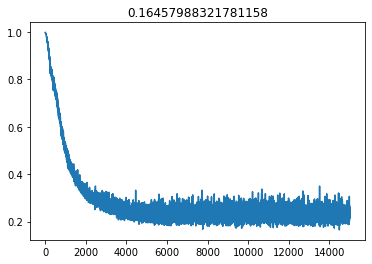

In [16]:
plt.plot(history.history['loss'])
plt.title(min(history.history['loss']))
plt.show()

In [16]:
base_model = MetricLearning()
base_model.load_weights(f'./checkpoints/triplet_model.h5')
base_model.trainable = False

#### TSNE 

In [18]:
df_0.pop(34)
df_0_ = tf.data.Dataset.from_tensor_slices(df_0)
df_0_ = df_0_.batch(1)
df_1.pop(34)
df_1_ = tf.data.Dataset.from_tensor_slices(df_1)
df_1_ = df_1_.batch(1)
df_2.pop(34)
df_2_ = tf.data.Dataset.from_tensor_slices(df_2)
df_2_ = df_2_.batch(1)

In [19]:
len(df_0_), len(df_1_), len(df_2_)

(700, 701, 500)

In [20]:
result_0 = base_model.predict(df_0_)
result_1 = base_model.predict(df_1_)
result_2 = base_model.predict(df_2_)

In [21]:
result_0_tsne = TSNE(learning_rate=300).fit_transform(result_0)
result_1_tsne = TSNE(learning_rate=300).fit_transform(result_1)
result_2_tsne = TSNE(learning_rate=300).fit_transform(result_2)

In [22]:
len(result_0_tsne), len(result_1_tsne), len(result_2_tsne)

(700, 701, 500)

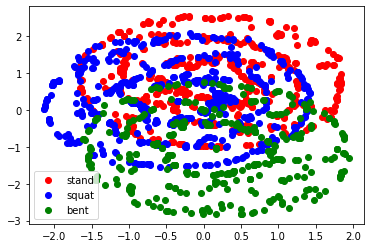

In [23]:
plt.scatter(result_0_tsne[:,0], result_0_tsne[:,1], color='red', label='stand')
plt.scatter(result_1_tsne[:,0], result_1_tsne[:,1], color='blue', label='squat')
plt.scatter(result_2_tsne[:,0], result_2_tsne[:,1], color='green', label='bent')
plt.legend()
plt.show()

#### PCA

In [25]:
result_0_pca = PCA(n_components=2).fit_transform(result_0)
result_1_pca = PCA(n_components=2).fit_transform(result_1)
result_2_pca = PCA(n_components=2).fit_transform(result_2)

/home/sungjin/anaconda3/envs/MetricLearning/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/sungjin/anaconda3/envs/MetricLearning/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [26]:
len(result_0_pca), len(result_1_pca), len(result_2_pca)

(700, 701, 500)

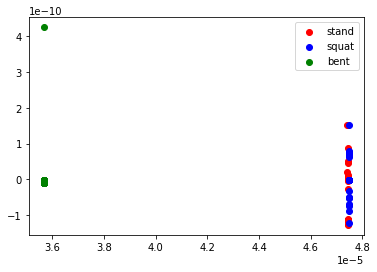

In [27]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(result_0_pca[:,0], result_0_pca[:,1], color='red', label='stand')
plt.scatter(result_1_pca[:,0], result_1_pca[:,1], color='blue', label='squat')
plt.scatter(result_2_pca[:,0], result_2_pca[:,1], color='green', label='bent')

# ax.scatter(result_0_pca[:,0], result_0_pca[:,1], result_0_pca[:,2], color='red', label='stand')
# ax.scatter(result_1_pca[:,0], result_1_pca[:,1], result_1_pca[:,2], color='blue', label='squat')
# ax.scatter(result_2_pca[:,0], result_2_pca[:,1], result_2_pca[:,2], color='green', label='bent')
plt.legend()
plt.show()

# Classification Model

#### Load Data 

In [28]:
df_0 = pd.read_csv(f'./target_0.csv', header=None)
df_1 = pd.read_csv(f'./target_1.csv', header=None)
df_2 = pd.read_csv(f'./target_2.csv', header=None)

In [50]:
# df = pd.concat([df_0, df_1, df_2], axis=0, ignore_index=True)
df = pd.concat([df_0, df_1], axis=0, ignore_index=True)

#### Split train & test Data 

In [51]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED)

y_train, y_val = train_df.pop(34), validation_df.pop(34)

train_dataset = tf.data.Dataset.from_tensor_slices((train_df.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((validation_df.values, y_val.values))

train_dataset = train_dataset.shuffle(len(df)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

f,v = next(iter(train_dataset))
f.shape, v.shape

(TensorShape([64, 34]), TensorShape([64]))

In [59]:
with tf.device('/device:GPU:0'):
    base_model = MetricLearning()
    base_model.load_weights(f'./checkpoints/triplet_model.h5')
    base_model.trainable = False
    
    classification_model = tf.keras.Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
classification_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_15 (Functional)   (None, 128)               37504     
_________________________________________________________________
dense_39 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 514       
Total params: 136,834
Trainable params: 99,330
Non-trainable params: 37,504
_________________________________________________________________


# Compile

In [60]:
# optimizer = tfa.optimizers.AdamW(learning_rate, wd)
optimizer = tf.keras.optimizers.SGD(0.01)

classification_model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

#### callbacks

In [61]:
checkpoint_filepath = './checkpoints/classification.h5'
# checkpoint_filepath = './checkpoints/best_model/'
mon = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False,
                                                monitor='val_accuracy', mode='max', save_best_only=True,
                                        verbose=1)

def trianfle_fn(x):
    return 1. / (2.**(x - 1))
clr_f = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = max_lr,
    maximal_learning_rate = min_lr,
    step_size = cycle_len,
    scale_fn = trianfle_fn
)

clr = tf.keras.callbacks.LearningRateScheduler(clr_f)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, 
                                          verbose=2, mode='auto', baseline=None, 
                                          restore_best_weights=True)

# Callbacks
# callbacks = [mon, clr, es]

# delete checkpoint
# callbacks = [clr, es]

# delete EarlyStop
# callbacks = [mon, clr]

# Only Scheduler
# callbacks = [clr]

callbacks = []

# Training

In [62]:
history = classification_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/100
18/18 [==============================] - 0s 5ms/step - loss: 0.9202 - accuracy: 0.4857 - val_loss: 0.7154 - val_accuracy: 0.5160
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.8414 - accuracy: 0.5080 - val_loss: 0.7526 - val_accuracy: 0.4840
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.8429 - accuracy: 0.5071 - val_loss: 0.6926 - val_accuracy: 0.5160
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7832 - accuracy: 0.4982 - val_loss: 0.6945 - val_accuracy: 0.4840
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7550 - accuracy: 0.5223 - val_loss: 0.6927 - val_accuracy: 0.5160
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7542 - accuracy: 0.5080 - val_loss: 0.6928 - val_accuracy: 0.5160
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7498 - accuracy: 0.4696 - val_loss: 0.6967 - val_accuracy: 0.5160
Epoch 8/100
1

Epoch 59/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7126 - accuracy: 0.5152 - val_loss: 0.6926 - val_accuracy: 0.5160
Epoch 60/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.4777 - val_loss: 0.6938 - val_accuracy: 0.4840
Epoch 61/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7016 - accuracy: 0.5188 - val_loss: 0.6927 - val_accuracy: 0.5160
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.4866 - val_loss: 0.6953 - val_accuracy: 0.4840
Epoch 63/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.4857 - val_loss: 0.6933 - val_accuracy: 0.4840
Epoch 64/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.4884 - val_loss: 0.6973 - val_accuracy: 0.4840
Epoch 65/100
18/18 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.4982 - val_loss: 0.6947 - val_accuracy: 0.4840
Epoch 

In [44]:
f,r = next(iter(train_dataset))

In [48]:
f, r

(<tf.Tensor: shape=(64, 34), dtype=float64, numpy=
 array([[0.06043733, 0.08715324, 0.01186559, ..., 0.84003295, 0.99846024,
         0.76080478],
        [0.03650989, 0.43800523, 0.00653438, ..., 0.84986763, 0.99959717,
         0.36944339],
        [0.07230276, 0.97538656, 0.04380478, ..., 0.23357807, 1.        ,
         0.23562588],
        ...,
        [0.03656961, 0.46037394, 0.00402687, ..., 0.90659903, 0.97683734,
         0.21824021],
        [0.04831538, 0.62878077, 0.00847701, ..., 0.57126516, 0.9900931 ,
         0.29768538],
        [0.02887557, 0.35651268, 0.00469142, ..., 0.90606234, 0.99762668,
         0.8603775 ]])>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([2, 1, 2, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 2, 1, 0, 2,
        2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0])>)